TODO
- filter out patches that still have land in them due to error in halo
- cut ice out of da merge

In [1]:
# Working env variables
jupyterhub = False
smalltest = False

In [2]:
if jupyterhub:
    !pip install ..

In [3]:
import numpy as np
import cmocean
import xgcm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ecco_v4_py as ecco
import xmitgcm.llcreader as llcreader

import dask.array as da
from dask.distributed import Client

import tqdm

import xarray as xr
import pandas as pd

import uuid

import zarr

In [4]:
import data_ingestion.get_raw_data as get_raw_data
import utils.native_gradient as ng
import plotting.llc_plotting as llc_plotting

import data_preprocessing.preproc_llc_core_data as preproc_llc_core_data
import utils.physical_calculations as physical_calculations

import data_preprocessing.weighted_coordinate_sampling as weighted_coordinate_sampling

import data_preprocessing.halo_mask as halo_mask
import data_preprocessing.spatial_patches as spatial_patches
import dataset_creation.metadata as metadata

import data_preprocessing.stats as stats



In [5]:
feature_channels = ["Eta", "Salt", "Theta", "U", "V", "W", "log_gradb"]
target_km_res = 150 #km
down_sample_res = 64 #pixels
halo_km = target_km_res #buffer to account for mean usage

In [6]:
# set up dask distributed client
dask_client = Client()  # default: uses all local cores
dask_client

<Client: 'tcp://127.0.0.1:63670' processes=4 threads=12, memory=31.10 GiB>

In [7]:
# loop through all existing files

timestep_hours = 12                     # how many hours to load
sampling_step = 12                      # stride in timesteps
ts_per_hour = 144                       # model cadence: 25 s → 144 steps/hr
iter_step = sampling_step * ts_per_hour # iteration Δ between samples
face_range = range(13)

# NOTE MAX iteration : 1495008

# First valid wind/forcing record begins ~1180
start_record = 1180

# Compute iter numbers
start_iter = 10368 + start_record * ts_per_hour
end_iter = 1495008 #start_iter + timestep_hours * ts_per_hour
iter_range = np.arange(start_iter, end_iter, iter_step)

endpoint_url = 'https://mghp.osn.xsede.org'

In [8]:
# files = []
# for it in iter_range:
#     files.append(get_raw_data.get_remote_llc_data(endpoint_url, it, face_range))

In [9]:
it = iter_range[0]

co = get_raw_data.get_remote_gridfile(endpoint_url)
ds = get_raw_data.get_remote_llc_data(endpoint_url, it, face_range)

ds_merge, ds_grid = preproc_llc_core_data.process_llc4320(ds, co)


Opening 13 Kerchunk JSON files...
Parsing JSON metadata into Python dicts...
Creating lazy xarray datasets...
Computing delayed datasets...
Combining datasets by coordinates...
Dataset combined successfully.


In [10]:
if smalltest:
    ds_merge = ds_merge.isel(face = slice(0,1)) # grab the first face but keep face coords
    ds_grid = ds_grid.isel(face= slice(0,1))

# grid = xgcm.Grid(ds_grid, coords={'X':{'center':'XC'}}, periodic=False)
grid = xgcm.Grid(ds_grid, periodic=False)

In [11]:
ds_merge

<xarray.Dataset> Size: 19GB
Dimensions:  (face: 13, j: 4320, i: 4320, i_g: 4320, j_g: 4320, k_p1: 2, k_u: 1)
Coordinates:
  * face     (face) float64 104B 0.0 1.0 2.0 3.0 4.0 ... 8.0 9.0 10.0 11.0 12.0
  * j        (j) float64 35kB 0.0 1.0 2.0 3.0 ... 4.317e+03 4.318e+03 4.319e+03
  * i        (i) float64 35kB 0.0 1.0 2.0 3.0 ... 4.317e+03 4.318e+03 4.319e+03
  * i_g      (i_g) float64 35kB 0.0 1.0 2.0 ... 4.317e+03 4.318e+03 4.319e+03
  * j_g      (j_g) float64 35kB 0.0 1.0 2.0 ... 4.317e+03 4.318e+03 4.319e+03
  * k_p1     (k_p1) float64 16B 0.0 1.0
  * k_u      (k_u) float64 8B 0.0
    k        float64 8B 0.0
    k_l      float64 8B 0.0
    niter    float64 8B dask.array<chunksize=(), meta=np.ndarray>
    time     datetime64[ns] 8B 2011-11-01T04:00:00
Data variables: (12/19)
    Eta      (face, j, i) float32 970MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    Salt     (face, j, i) float32 970MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    Theta    (face, j, i) float32 970MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    U        (face, j, i_g) float32 970MB dask.array<chunksize=(1, 720, 360), meta=np.ndarray>
    V        (face, j_g, i) float32 970MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    W        (face, j, i) float32 970MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    ...       ...
    rA       (face, j, i) float32 970MB dask.array<chunksize=(1, 360, 360), meta=np.ndarray>
    Depth    (face, j, i) float32 970MB dask.array<chunksize=(1, 360, 360), meta=np.ndarray>
    hFacC    (face, j, i) float32 970MB dask.array<chunksize=(1, 360, 360), meta=np.ndarray>
    SN       (face, j, i) float32 970MB dask.array<chunksize=(1, 360, 360), meta=np.ndarray>
    CS       (face, j, i) float32 970MB dask.array<chunksize=(1, 360, 360), meta=np.ndarray>
    maskC    (face, j, i) float64 2GB dask.array<chunksize=(1, 360, 360), meta=np.ndarray>
Attributes:
    history:  Created by C. Spencer Jones using https://github.com/cspencerjo...
    source:   MITgcm
    title:    Chunked netcdf created from MITgcm LLC4320 surface output

In [12]:
# llc_plotting.plot_llc_faces_layout( ds_merge.Theta, vmin=-4, vmax=40 )

In [13]:
# first order approximation of freezing point
#tf = -0.056S - 0.008
freezing_point_tol = 0.5 #0.05
ice_mask = ds_merge.Theta <= ((-0.056*ds_merge.Salt) - 0.008 + freezing_point_tol)

# ice_mask = ds_merge.Theta <= -1.8
# ice_mask = ds_merge.Theta <= 0.0

halo_land_mask = halo_mask.llc_halo_mask(
    mask=ds_grid.hFacC == 0,
    dxC=ds_grid["dxC"],
    dyC=ds_grid["dyC"],
    halo_km=halo_km
)

halo_ice_mask = halo_mask.llc_halo_mask(
    mask=ice_mask,
    dxC=ds_grid["dxC"],
    dyC=ds_grid["dyC"],
    halo_km=halo_km
)

faces_perimeter_mask = xr.zeros_like(ds_merge.Theta).astype(bool)
faces_perimeter_mask.loc[dict(j=0)] = True
faces_perimeter_mask.loc[dict(j=(faces_perimeter_mask.coords.sizes["j"]-1) )] = True
faces_perimeter_mask.loc[dict(i=0)] = True
faces_perimeter_mask.loc[dict(i=(faces_perimeter_mask.coords.sizes["i"]-1) )] = True

halo_faces_perimeter_mask = halo_mask.llc_halo_mask(
    mask=faces_perimeter_mask,
    dxC=ds_grid["dxC"],
    dyC=ds_grid["dyC"],
    halo_km=halo_km
)

In [14]:
merged_mask = halo_ice_mask & halo_land_mask & halo_faces_perimeter_mask

In [15]:
cmap_bool = colors.ListedColormap(['red', 'green'])

In [16]:
# ds_merge.dxC[0].max().compute()

In [17]:
# ds_merge.dxC[0].min().compute()

In [18]:
# ds_merge.dxC[0].mean().compute()

In [20]:
#llc_plotting.plot_llc_faces_layout(xr.DataArray(merged_mask), color_map=cmap_bool, is_mask=True, vmin=0, vmax=1)

In [21]:
# print("da.dims:", ds_merge.dims)
# print("mask.dims:", merged_mask.dims)

In [22]:
# cmap_bool = colors.ListedColormap(['red', 'green'])

# #llc_plotting.plot_a_face_by_var(xr.DataArray(merged_mask), 0, color_map=cmap_bool, vmin=0, vmax=1)
# llc_plotting.plot_llc_faces_layout(xr.DataArray(merged_mask), color_map=cmap_bool, is_mask=True, vmin=0, vmax=1)

In [23]:
# Meridional and Zonal Gradient of theta
ds_dx_hatx_G, ds_dy_haty_G = ng.calculate_native_gradient_tracer(ds_merge.Theta, ds_grid, grid=grid)

In [24]:
buoyancy = physical_calculations.buoyancy_of_field(ds_merge)

# gradient of b
zonal_grad_b, merid_grad_b = ng.calculate_native_gradient_tracer(buoyancy, ds_grid, grid=grid)

zonal_grad_b = zonal_grad_b.persist()
merid_grad_b = merid_grad_b.persist()

gradb2 = physical_calculations.grad_squared(zonal_grad_b, merid_grad_b)
gradb2 = gradb2.persist()


log_gradb = da.log10(gradb2)
log_gradb.persist()

log_gradb_ds = log_gradb.to_dataset(name="log_gradb")
ds_merge = xr.merge([ds_merge, log_gradb_ds])

# Sample data points weighted toward high gradient values

## Option 1 : Sample from gradients directly on the grid

This is the best option I believe

slowish

In [25]:
# llc_plotting.plot_llc_faces_layout(log_gradb)

In [26]:
bias_to_high_gradients = 3 # 0.5  # < 1 flattens, > 1 sharpens

SAMPLE_POINTS = 100 # todo what do we want here?

if smalltest:
    SAMPLE_POINTS = 50

In [28]:
# display weights

weights = np.exp(bias_to_high_gradients * (log_gradb - log_gradb.min(skipna=True)))

# weights = log_gradb # - log_gradb.max()
# weights = np.exp(bias_to_high_gradients * weights)

weights = weights.where(merged_mask)
# weights = weights.where(~np.isnan(weights))
p = weights / weights.sum()

#llc_plotting.plot_llc_faces_layout(da.log10(p))

C:\Users\Jake Tallman\PycharmProjects\dbof-in-native-grid\.venv1\Lib\site-packages\distributed\client.py:3370: UserWarning: Sending large graph of size 231.69 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


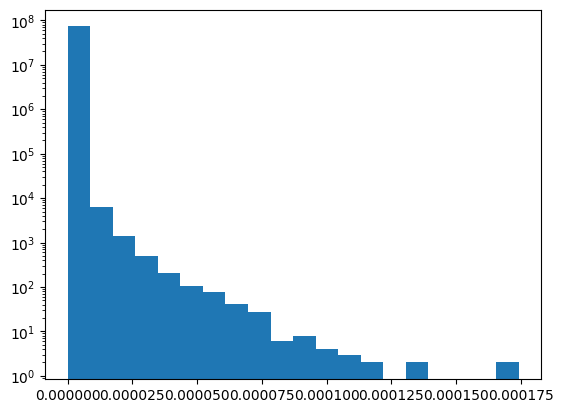

In [29]:
plt.hist(p.values.flatten(), bins=20)
plt.yscale("log")
plt.show()

In [30]:
# # sample on grid
indices = weighted_coordinate_sampling.weighted_sample_on_grid(SAMPLE_POINTS, bias_to_high_gradients, log_gradb, merged_mask)

C:\Users\Jake Tallman\PycharmProjects\dbof-in-native-grid\.venv1\Lib\site-packages\distributed\client.py:3370: UserWarning: Sending large graph of size 231.88 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
C:\Users\Jake Tallman\PycharmProjects\dbof-in-native-grid\.venv1\Lib\site-packages\distributed\client.py:3370: UserWarning: Sending large graph of size 510.23 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
C:\Users\Jake Tallman\PycharmProjects\dbof-in-native-grid\.venv1\Lib\site-packages\distributed\client.

## Option 2 Sample from pdf and find matching values in the grid

In [43]:
# x = log_gradb.values  # loads data into memory
#
# samples = weighted_coordinate_sampling.sample_linearly_on_pdf(x, SAMPLE_POINTS, False)
# tolerance = 5e-7
# indices2 = weighted_coordinate_sampling.find_coords_first_parallel(x, samples, tol=tolerance, n_jobs=3) # this uses a lot of ram but is pretty fast

# Generate Spatial Patches from Our Indices

In [31]:
# Move non tracer values to tracer points
# only run this once or weird stuff happens
ds_merge["V"] = grid.interp(ds_merge["V"], 'Y', boundary='fill')
ds_merge["U"] = grid.interp(ds_merge["U"], 'X', boundary='fill')

In [32]:
# S3 Configuration
bucket = "llc/"
folder = "native_grid_dbof_training_data/"
run_id = "small_test/"

s3_endpoint = "https://s3-west.nrp-nautilus.io"

In [33]:
# set up metadata
import s3fs

meda_data_file_path = "s3://" + bucket + folder + run_id + "metadata/metadata.parquet",

metadata_cols = [
    "id",
    "dataset_index",
    "native_grid",
    "center_grid_face",
    "center_grid_j",
    "center_grid_i",
    "center_lat",
    "center_lon",
    "target_km_res",
    "real_km_w",
    "real_km_h",
    "pre_interp_res",
    "log_grad_b_2_center",

    "time_snapshot" # todo need info from model docs to get this - could store index for now
]

fs = s3fs.S3FileSystem(
    client_kwargs={
        "endpoint_url": s3_endpoint,
    },
    config_kwargs={
        "s3": {"addressing_style": "path"},
    },
)

metadata_writer = metadata.MetadataWriter(meda_data_file_path, flush_every=10000, fs = fs)

In [69]:
import boto3
from botocore.client import Config

s3 = boto3.client(
    "s3",
    endpoint_url=s3_endpoint,  # outside endpoint
    aws_access_key_id="30IGSHC0SOFATE1TUIZR",
    aws_secret_access_key="ovpwMceykWAK2EfH8YfsKzHmotqKiKY5jlpIgdkl",
    config=Config(
        s3={
            "addressing_style": "path",     # MUST be path-style
            "payload_signing_enabled": False,
            "signature_version":"s3v4",
            "multipart_threshold": "1GB",
            "multipart_chunksize" : "256MB",
            "max_bandwidth" : "200MB/s",
            "use_accelerate_endpoint" : False,
            "use_dualstack_endpoint" : False
        },
        region_name='us-east-1',
        signature_version="s3v4"
    )
)

# Upload a simple file
# s3.put_object(
#     Bucket="llc",               # just bucket name
#     Key=f"{folder}/{run_id}/test.txt",            # path within bucket
#     Body=b"hello"
# )

In [70]:
# s3.list_objects(Bucket="llc")

response = s3.put_object(
    Key=f"{folder}{run_id}test.txt",
    ACL='public-read',
    Body='aaaaaa',
    Bucket="llc",
)


#s3.upload_file("test.txt", "llc", f"{folder}{run_id}test.txt")


ClientError: An error occurred (XAmzContentSHA256Mismatch) when calling the PutObject operation: Unknown

In [45]:
# TODO create a class
import fsspec

# dataset_path = "dataset.zarr"

fs = fsspec.filesystem(
   's3', asynchronous=False,
   client_kwargs={"endpoint_url": s3_endpoint},
   config_kwargs={
        "s3": {
            "addressing_style": "path",
            "signature_version": "s3v4",
            "payload_signing_enabled": False,
        }
    },
)

# fs.put("s3://"+bucket+folder+run_id+"test.txt", b"hello")

with fs.open(bucket+folder+run_id+"test.txt", "wb") as f:  # "wb" = write bytes
    f.write(b"hello")

# # store = zarr.open_group(dataset_path, mode="a")
#
# store = zarr.storage.FsspecStore(
#     path=bucket+folder+run_id+"dataset.zarr",
#     fs=fs
# )
#
# root = zarr.open_group(store=store, mode="a")
#
# print(root)
#
# C, H, W = len(feature_channels), down_sample_res, down_sample_res
#
# if "images" not in root:
#     store.create_array(
#         "images",
#         shape=(0, C, H, W),
#         chunks=(1, C, H, W),
#         dtype="float32"
#     )

HTTPClientError: An HTTP Client raised an unhandled exception: Task <Task pending name='Task-582157' coro=<TCPConnector._resolve_host_with_throttle() running at C:\Users\Jake Tallman\PycharmProjects\dbof-in-native-grid\.venv1\Lib\site-packages\aiohttp\connector.py:1179>> got Future <Future pending cb=[_chain_future.<locals>._call_check_cancel() at C:\Users\Jake Tallman\AppData\Local\Programs\Python\Python312\Lib\asyncio\futures.py:389]> attached to a different loop

In [69]:
def append_image(zstore, img): # todo batch? and make this a class
    zstore["images"].append(np.expand_dims(img, axis=0), axis=0)
    n = store["images"].shape[0]
    return n   # zarr index

In [70]:
patches = []
print()
# this is our main loop of data creation
# todo parallelize obviously
for index in tqdm.tqdm(indices):
    if index is not None:
        patch_metadata = dict.fromkeys(metadata_cols)
        patch_metadata["id"] = str(uuid.uuid4())
        patch_metadata["native_grid"] = "LLC4320" # todo all supported for now
        patch_metadata["center_grid_face"] = index[0]
        patch_metadata["center_grid_j"] = index[1]
        patch_metadata["center_grid_i"] = index[2]
        patch_metadata["target_km_res"] = target_km_res
        patch_metadata["center_lat"] = ds_merge.YC[index].values.item()
        patch_metadata["center_lon"] = ds_merge.XC[index].values.item()
        patch_metadata["log_grad_b_2_center"] = (ds_merge.log_gradb[index].values.item())

        patch = spatial_patches.get_lat_lon_extents_of_patch(index, ds_merge, target_km_res)

        if(patch is None):
            print(indices)
            continue # todo we should log this somehow

        patches.append(patch)

        patch_metadata["real_km_w"] = patch["real_km_w"]
        patch_metadata["real_km_h"] = patch["real_km_h"]

        patch_img = ds_merge.Theta.isel(
            face=patch["face"],
            j=slice(patch["j_start"], patch["j_end"] + 1),
            i=slice(patch["i_start"], patch["i_end"] + 1)
        )
        patch_metadata["pre_interp_res"] = patch_img.shape
        img_patch = spatial_patches.create_image_patch(ds_merge, feature_channels, patch)
        data_sample = spatial_patches.downsample_image(img_patch)
        
        # add data to zarr
        idx = append_image(store, data_sample)
        patch_metadata["dataset_index"] = idx


        # add metadata
        metadata_writer.add(patch_metadata)

metadata_writer.close()

100%|██████████| 100/100 [02:45<00:00,  1.65s/it]


In [71]:
# note for display we must delete the metadata file before running sampling
meta_df = pd.read_parquet("metadata.parquet")

In [72]:
meta_df

id dataset_index native_grid  \
0   8ad0bfcb-7f3f-4f9f-b0ef-681bdd16b27f          None     LLC4320   
1   ec309f48-b739-414d-ad07-04c8da4b161e          None     LLC4320   
2   c7b749ae-f3e5-4065-a45a-60fafeecfa1b          None     LLC4320   
3   7099c88c-4101-442f-b6a8-9eec49abb254          None     LLC4320   
4   2e1e29c2-76b6-46a3-b8cd-f1aead502a69          None     LLC4320   
..                                   ...           ...         ...   
95  a5761644-568c-4e39-aa84-3ba2def2538f          None     LLC4320   
96  add69409-1f64-4b8b-878d-69d214ff3272          None     LLC4320   
97  cba4a3e0-d0d2-4529-abc0-236c28e61234          None     LLC4320   
98  052469e4-5dbb-42a6-a808-90c12589c3e6          None     LLC4320   
99  f8da2dc4-3acd-42d8-bff6-244adbc14fc9          None     LLC4320   

    center_grid_face  center_grid_j  center_grid_i  center_lat  center_lon  \
0                  7           2322            315   69.148193 -169.125397   
1                 10           1682           3726   24.464687  -92.947914   
2                  7            800           2573   42.770454  158.677078   
3                  7           1870           2493   43.898022 -179.031250   
4                  7            825           3735   24.307716  159.197922   
..               ...            ...            ...         ...         ...   
95                10           3382           1231   59.240322  -57.463310   
96                11           4150            148   10.952224  -41.531250   
97                10           3822           1379   57.616058  -48.360302   
98                 6           2348            342   75.089439    1.231764   
99                10           3734           1732   53.680294  -50.197918   

    target_km_res   real_km_w   real_km_h pre_interp_res  log_grad_b_2_center  \
0             150  149.168370  148.990487     [159, 143]           -18.245868   
1             150  147.265327  147.576902       [71, 77]           -18.900406   
2             150  148.528352  149.624159       [89, 95]           -19.807878   
3             150  149.144641  146.871474       [89, 97]           -18.987621   
4             150  147.447790  147.760310       [71, 77]           -18.990053   
..            ...         ...         ...            ...                  ...   
95            150  148.707372  149.328727     [127, 128]           -17.556255   
96            150  146.804900  145.536641       [65, 71]           -20.680198   
97            150  147.857650  148.825186     [121, 132]           -19.127573   
98            150  148.625896  148.599374     [171, 149]           -17.936484   
99            150  148.972081  148.161023     [109, 115]           -17.990100   

   time_snapshot  
0           None  
1           None  
2           None  
3           None  
4           None  
..           ...  
95          None  
96          None  
97          None  
98          None  
99          None  

[100 rows x 14 columns]

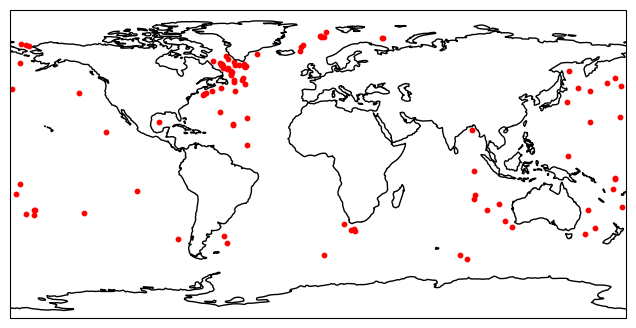

In [73]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

lats, lons = meta_df["center_lat"], meta_df["center_lon"]

fig = plt.figure(figsize=(8, 4))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.coastlines()
ax.set_global()
ax.scatter(
    lons,
    lats,
    s=10,
    color="red",
    transform=ccrs.PlateCarree()
)

plt.show()

In [35]:
meta_df["log_grad_b_2_center"]

0     -16.251257
1     -16.185837
2     -16.209006
3     -16.118815
4     -16.222903
         ...    
189   -16.865840
190   -16.855821
191   -16.708389
192   -16.813410
193   -17.031233
Name: log_grad_b_2_center, Length: 194, dtype: float64

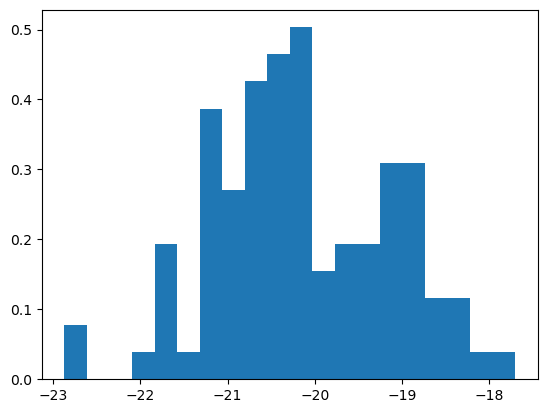

In [51]:
hist, edges = np.histogram(meta_df["log_grad_b_2_center"], bins=20, density=True)

plt.bar(
    edges[:-1],
    hist,
    width=np.diff(edges),
    align="edge"
)

plt.show()

In [ ]:
# # polar point
# latlon_dict = get_lat_lon_extents_of_patch((6, 2159, 2159), log_gradb, ds_merge, 150)
#
# #print(latlon_dict["lat_min"], latlon_dict["lat_max"], latlon_dict["lon_min"], latlon_dict["lon_max"])

In [ ]:
# # worst possible point for dx dy ratio 3 0 623
# latlon_dict = get_lat_lon_extents_of_patch((3, 700, 1023), log_gradb, ds_merge, 150)

In [ ]:
plt.figure(figsize=(8,8), dpi= 90)
plt.imshow(store["images"][0][4],origin='lower',cmap='jet')

(159, 143)
(71, 77)
(89, 95)
(89, 97)
(71, 77)
(129, 126)
(67, 71)
(113, 107)
(81, 88)
(123, 138)
(87, 94)
(93, 100)
(85, 92)
(127, 138)
(101, 107)
(115, 120)
(91, 97)
(67, 73)
(171, 149)
(65, 71)
(119, 127)


/tmp/ipykernel_4247/3348171623.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8,8), dpi= 90)


(173, 161)
(91, 97)
(73, 79)
(111, 116)
(65, 71)
(75, 81)
(115, 120)
(71, 77)
(85, 92)
(101, 108)
(137, 140)
(73, 79)
(159, 144)
(107, 112)
(140, 151)
(186, 170)
(125, 114)
(99, 105)
(87, 93)
(173, 152)
(89, 95)
(123, 136)
(87, 94)
(85, 92)
(65, 71)
(71, 77)
(67, 73)
(99, 105)
(87, 93)
(91, 97)
(143, 144)
(150, 161)
(95, 102)
(119, 124)
(71, 77)
(119, 129)
(148, 159)
(81, 87)
(171, 148)
(86, 79)
(113, 107)
(79, 73)
(88, 81)
(93, 99)
(75, 69)
(161, 146)
(123, 127)
(97, 104)
(121, 135)
(74, 69)
(121, 126)
(84, 77)
(173, 160)
(117, 122)
(75, 81)
(73, 79)
(111, 116)
(69, 75)
(111, 116)
(105, 110)
(67, 74)
(90, 83)
(77, 71)
(73, 79)
(75, 81)
(73, 80)
(95, 101)
(171, 148)
(71, 65)
(89, 83)
(75, 69)
(91, 83)
(73, 79)
(119, 115)
(127, 128)
(65, 71)
(121, 132)
(171, 149)
(109, 115)


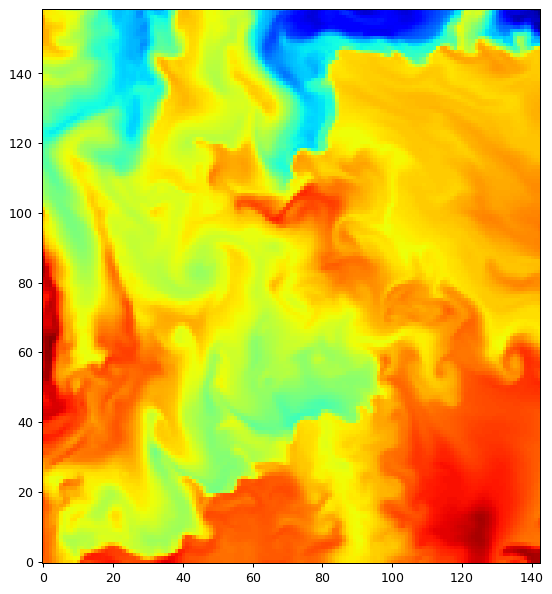

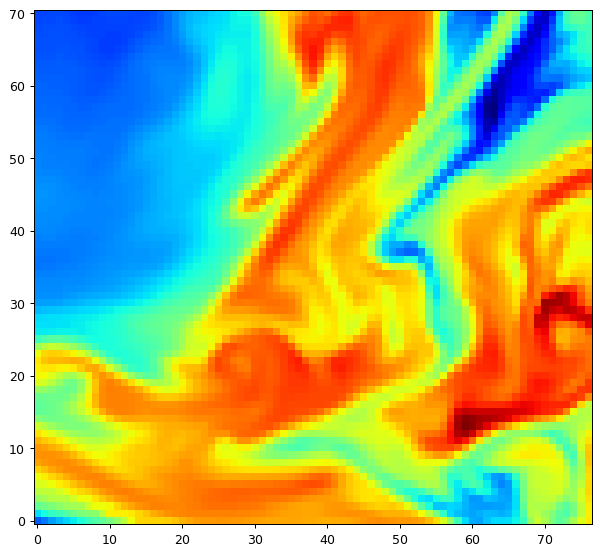

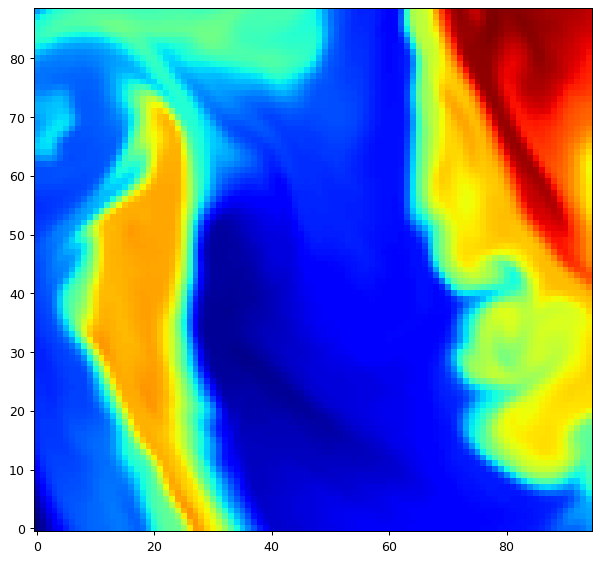

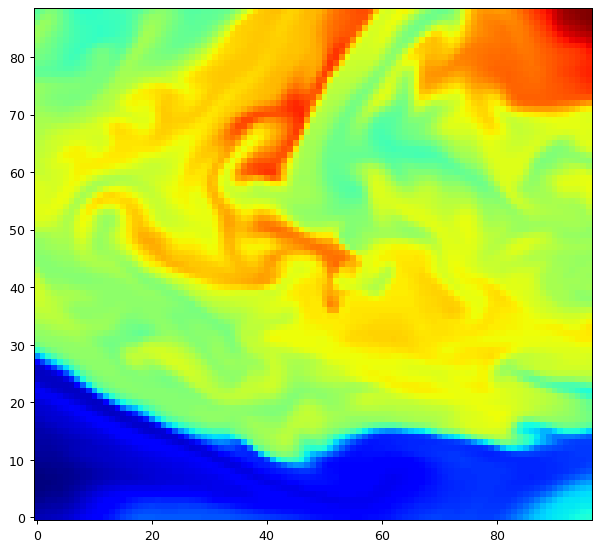

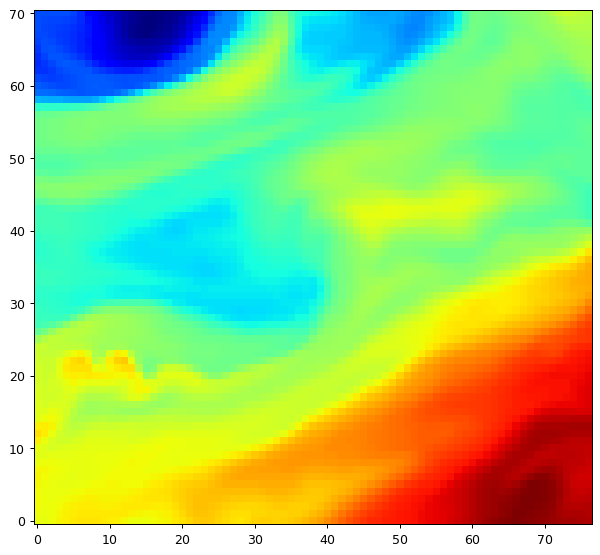

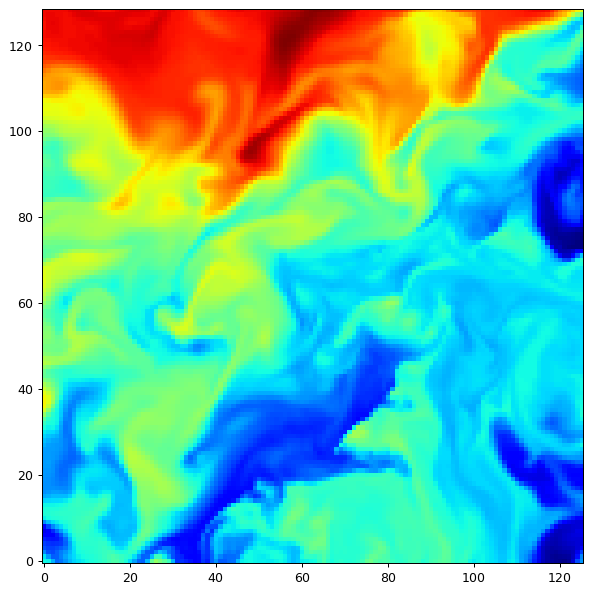

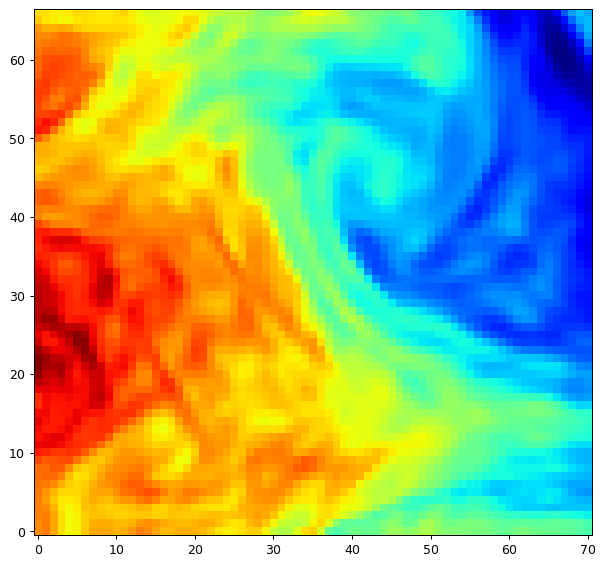

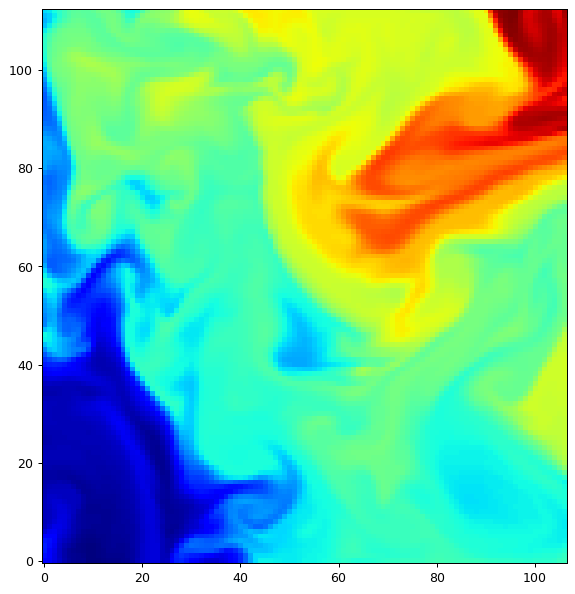

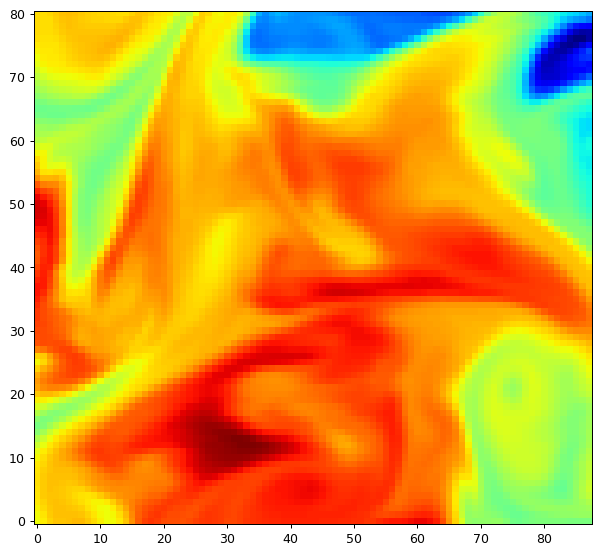

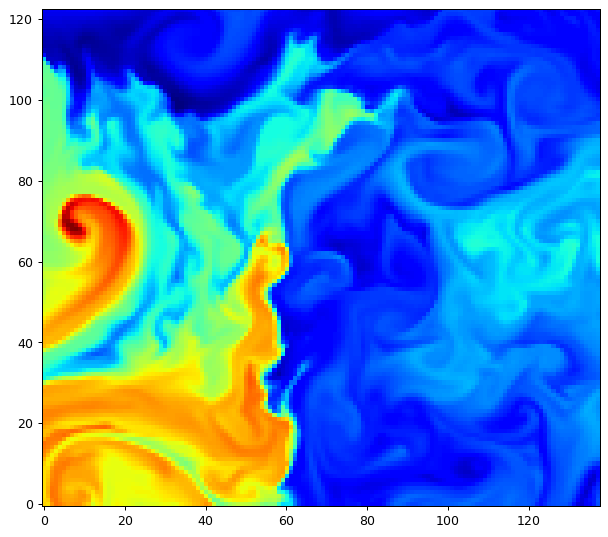

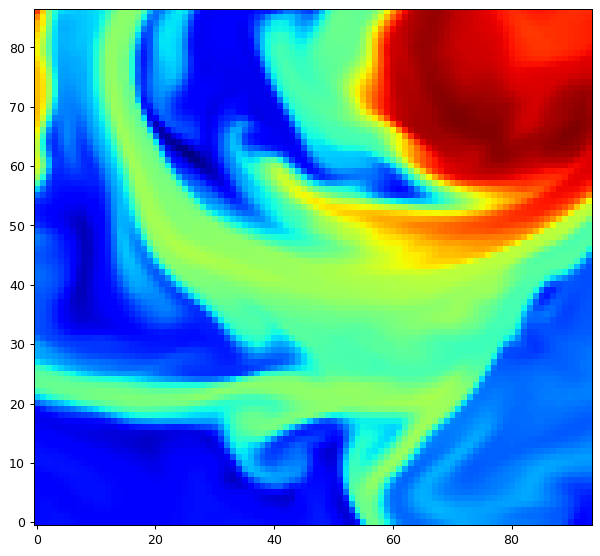

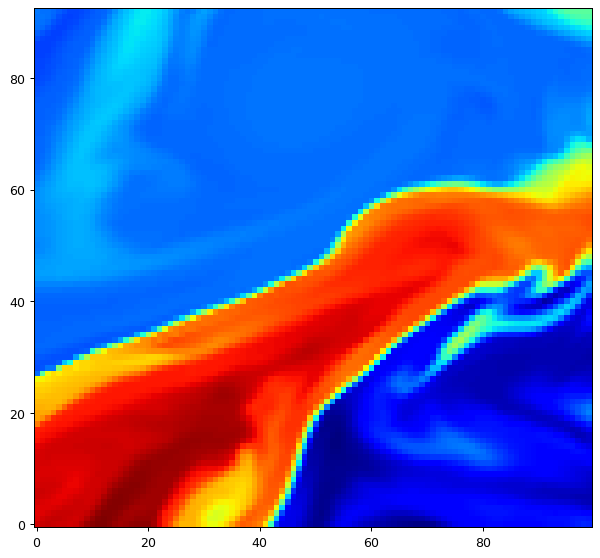

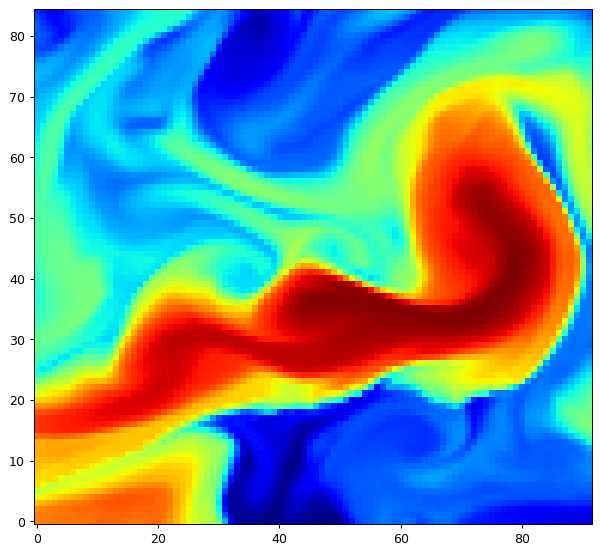

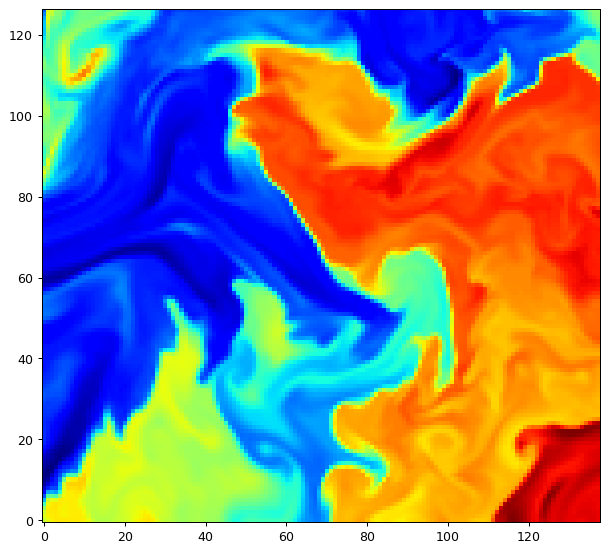

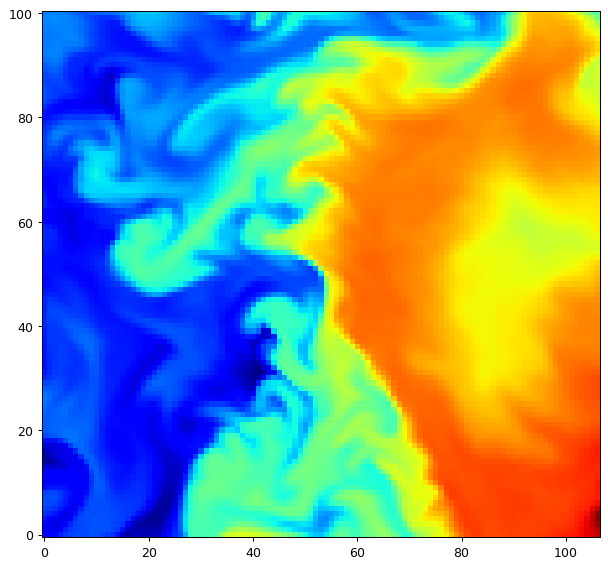

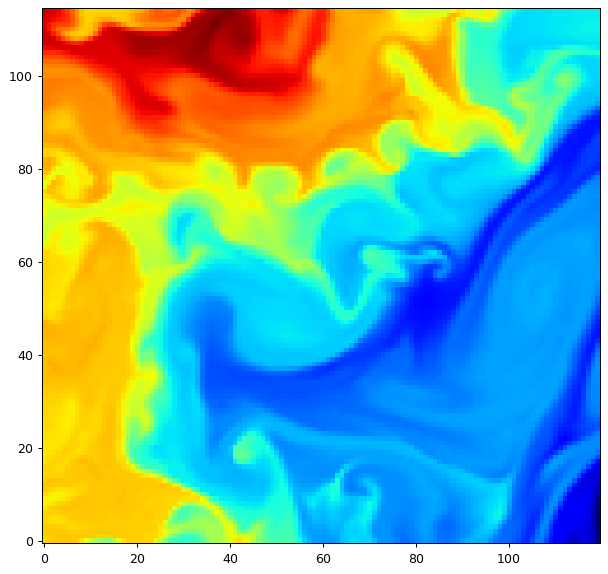

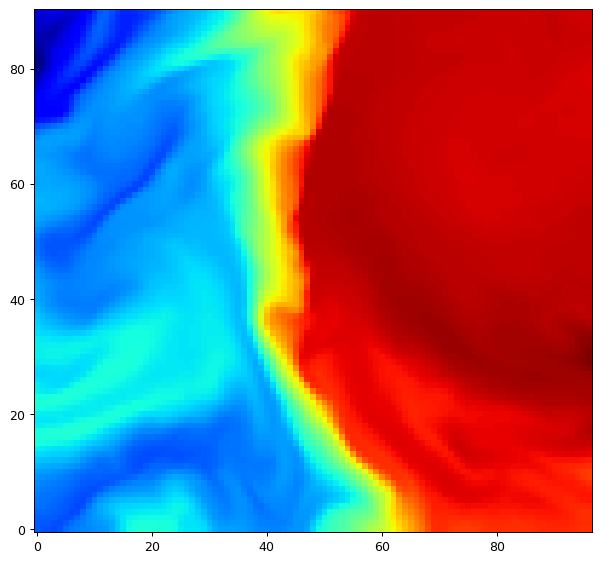

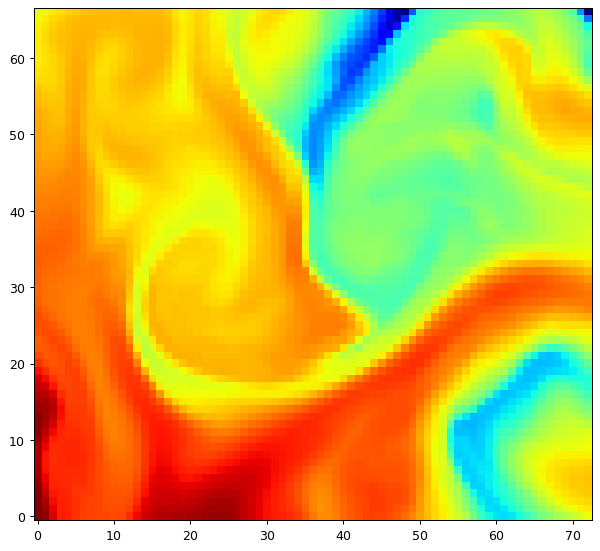

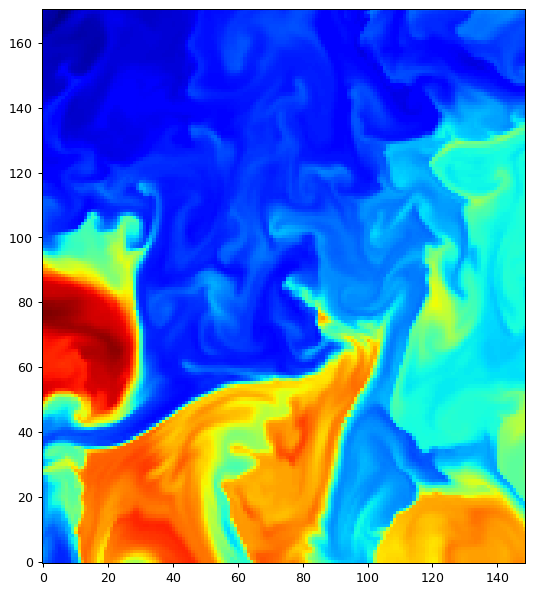

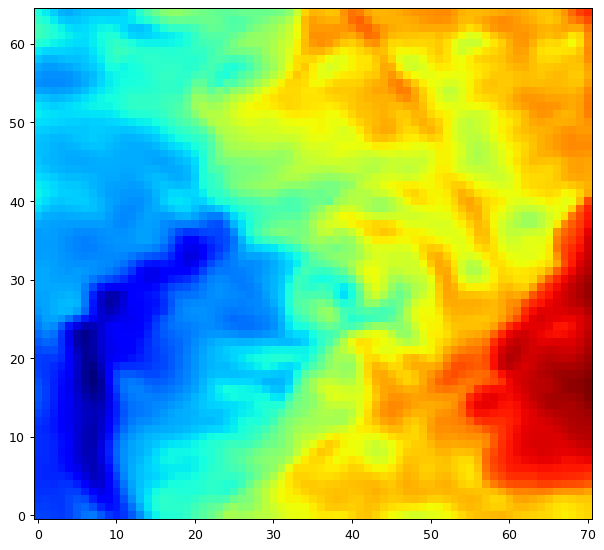

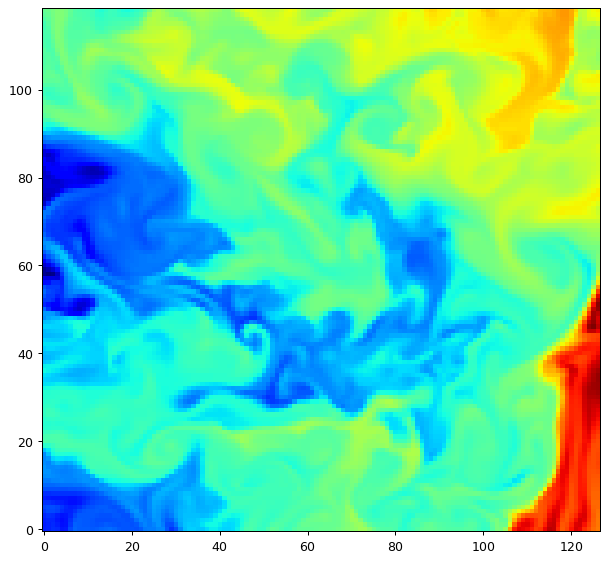

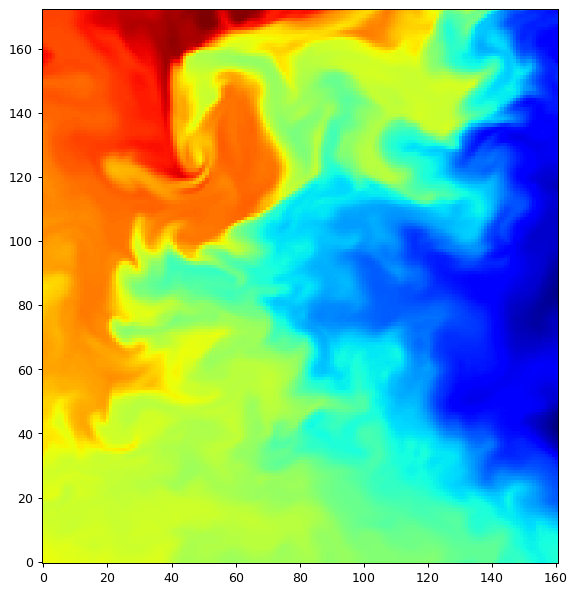

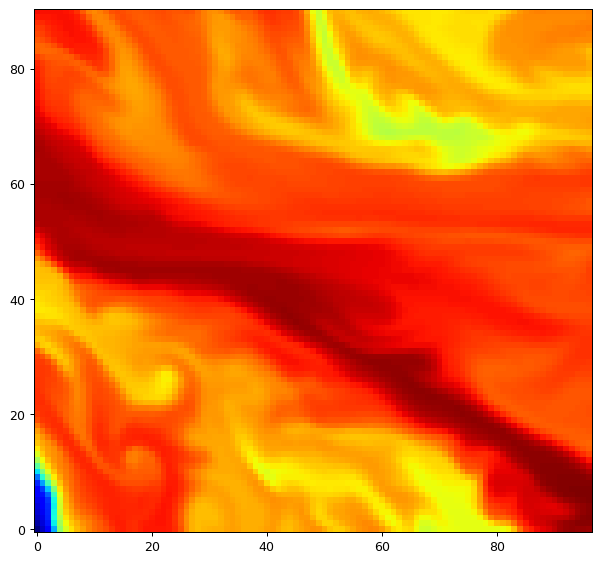

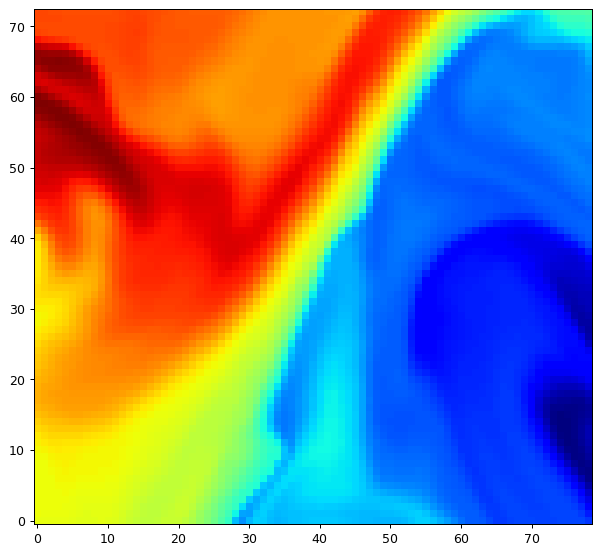

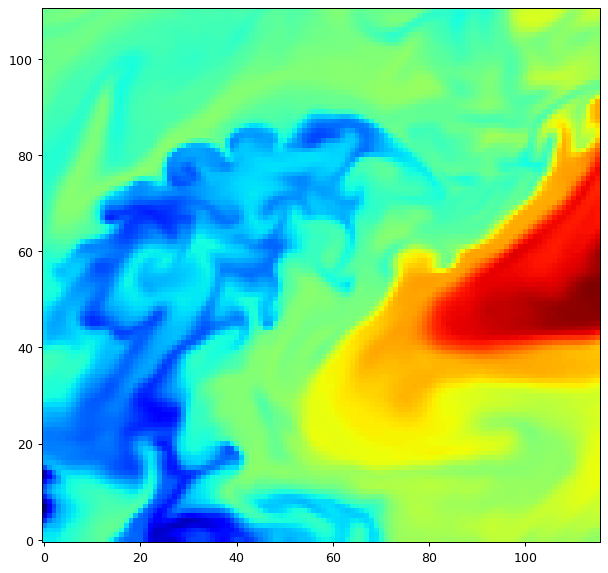

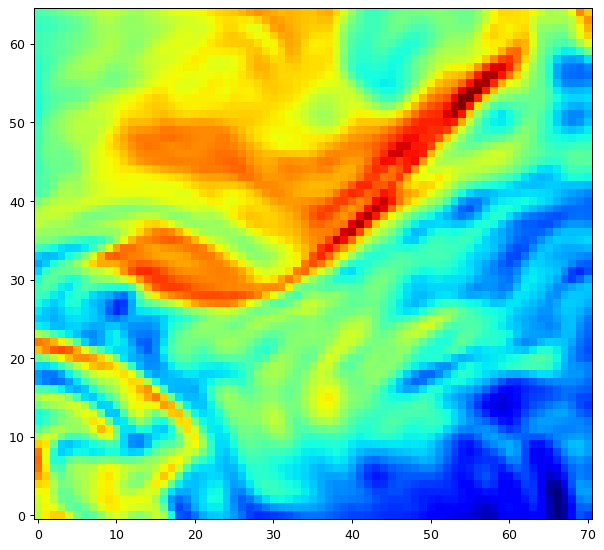

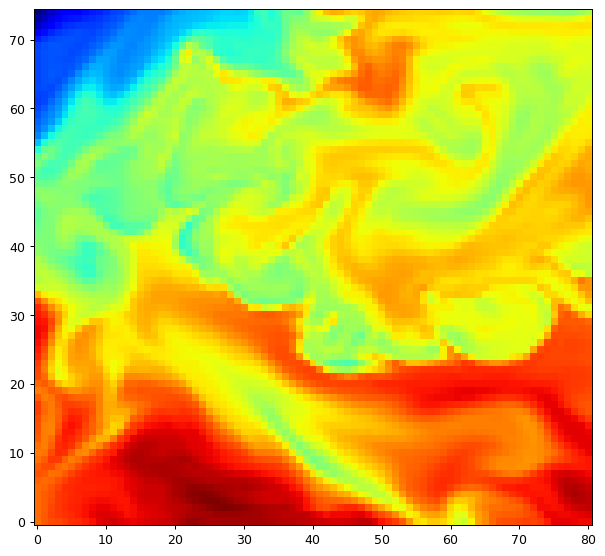

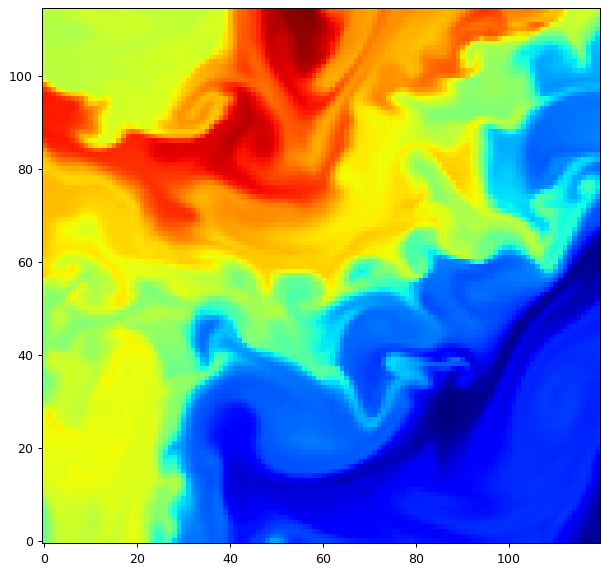

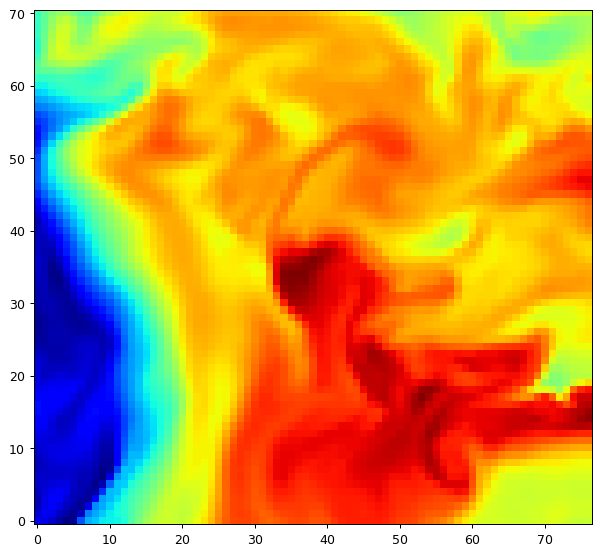

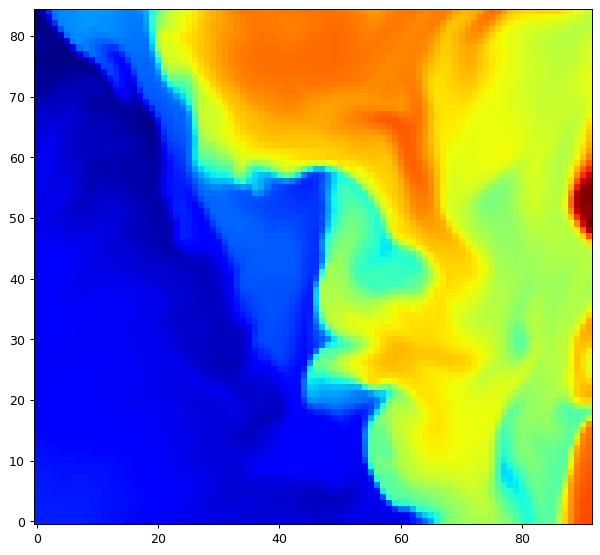

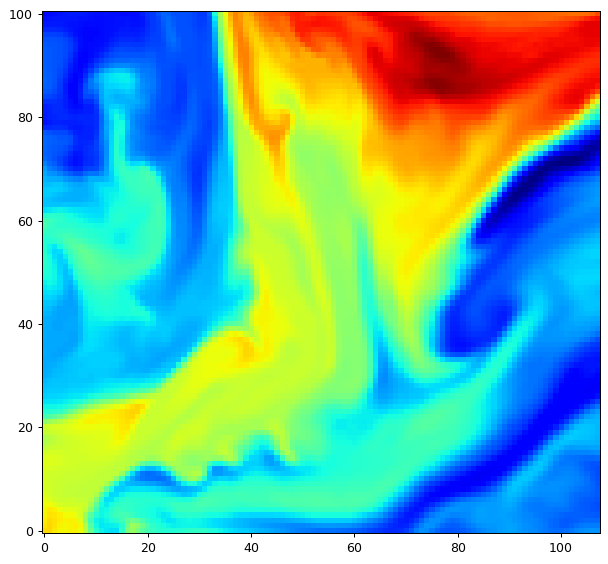

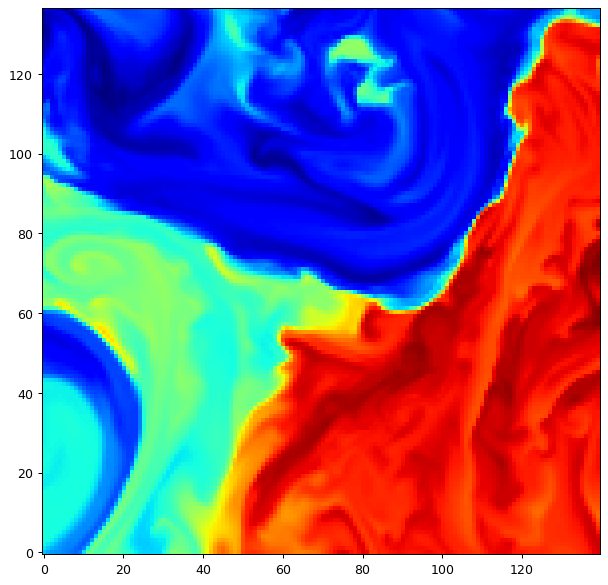

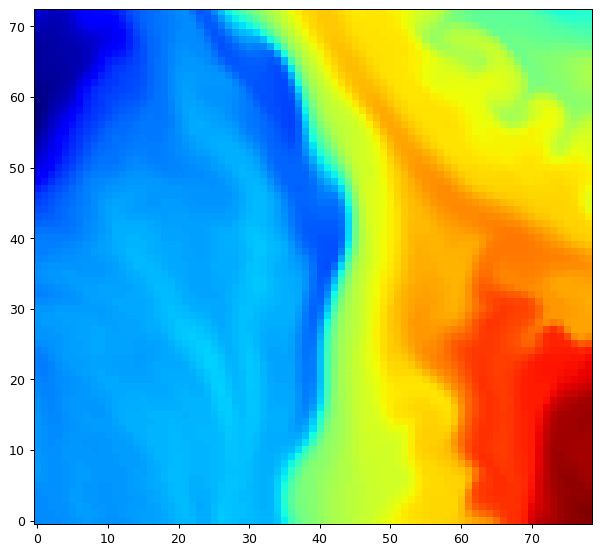

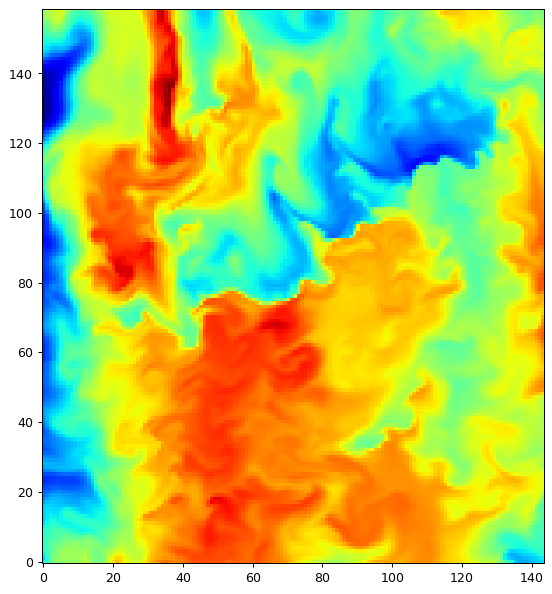

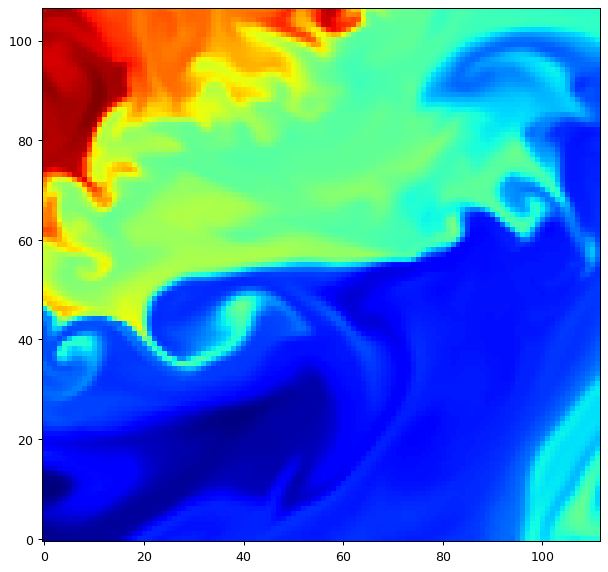

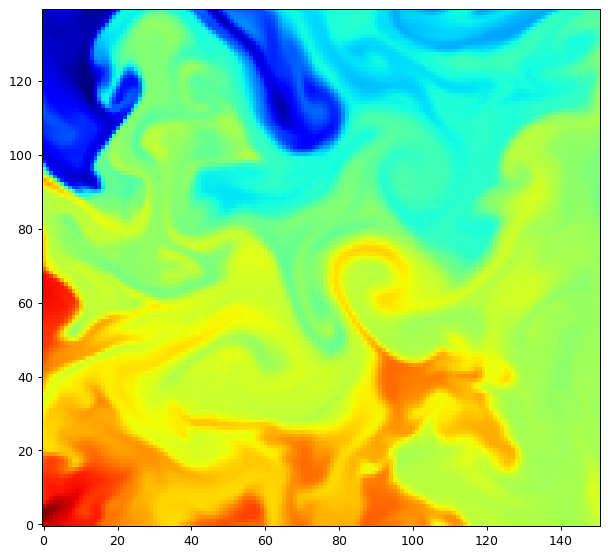

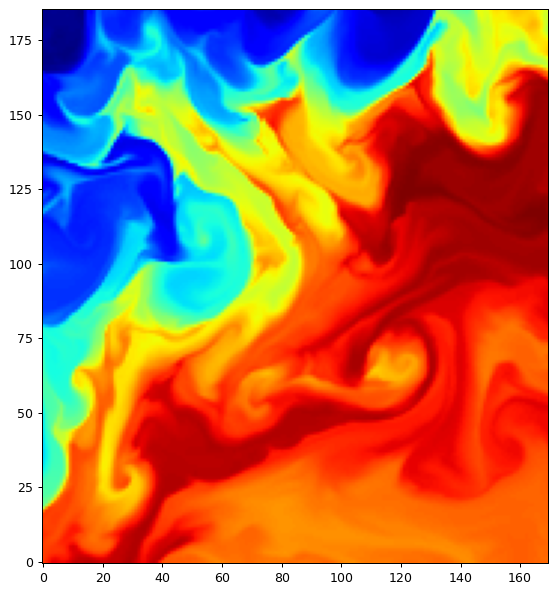

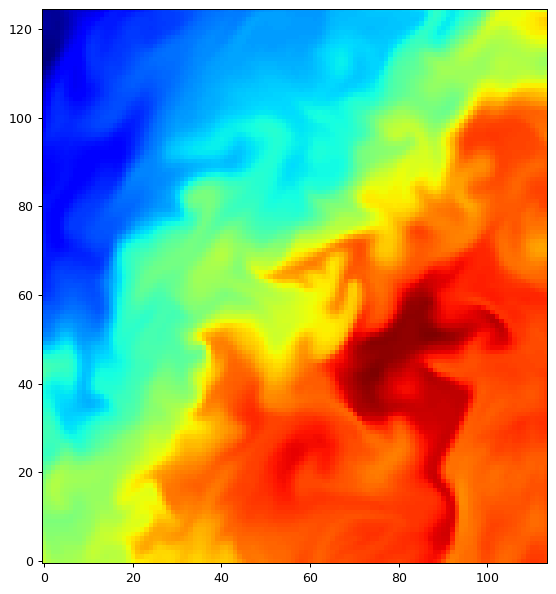

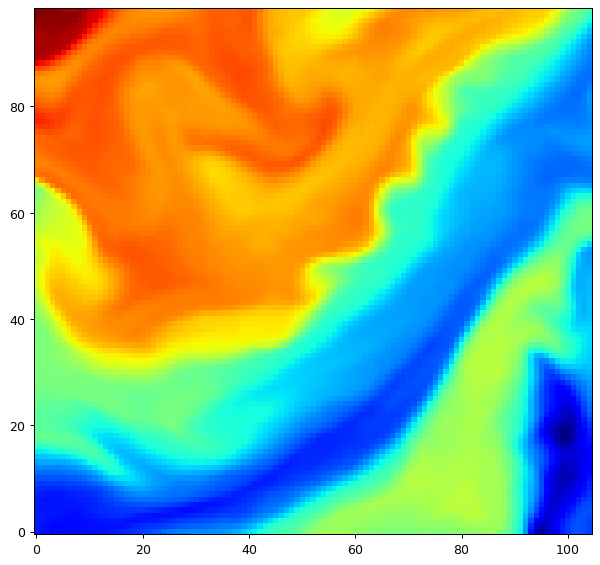

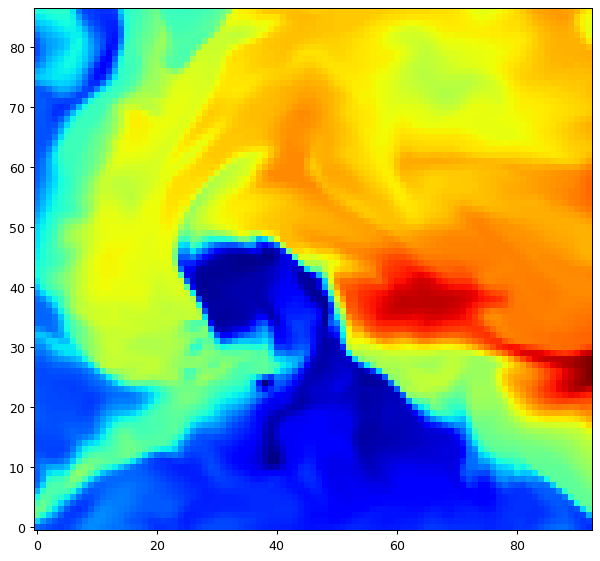

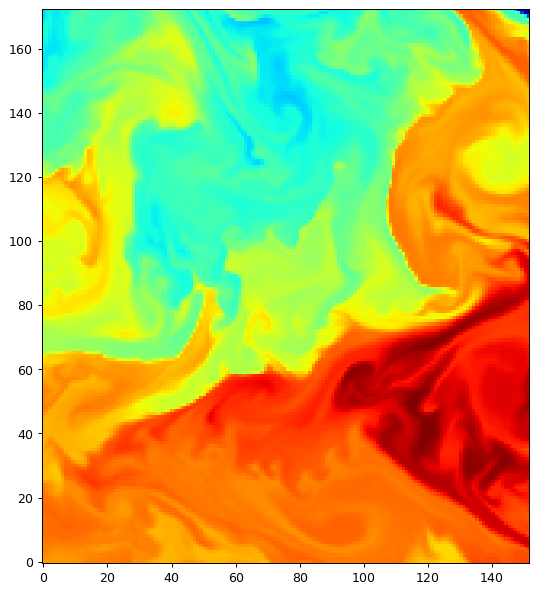

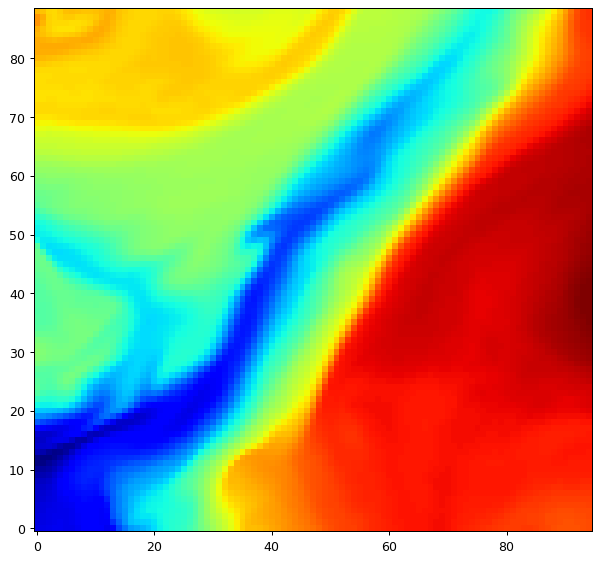

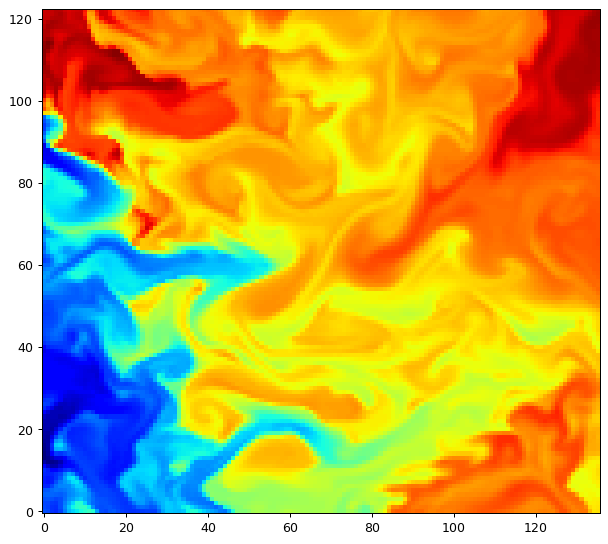

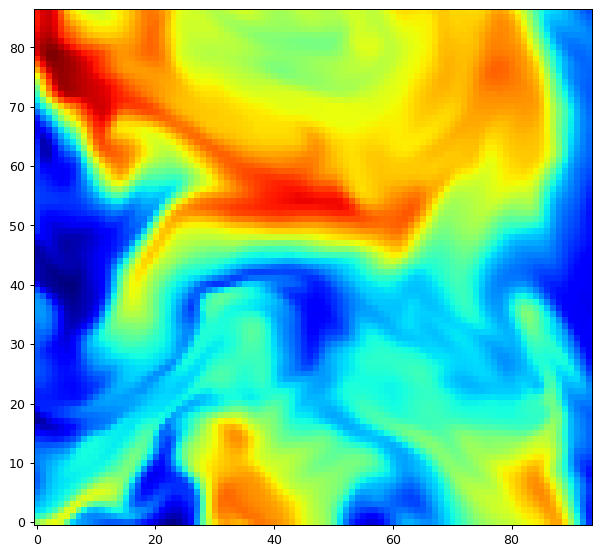

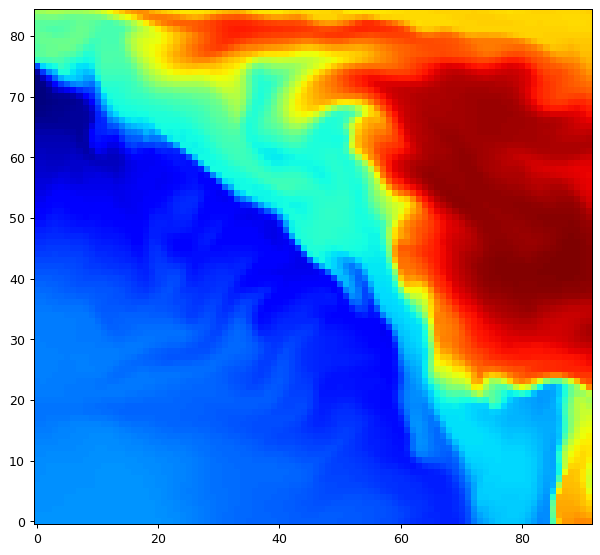

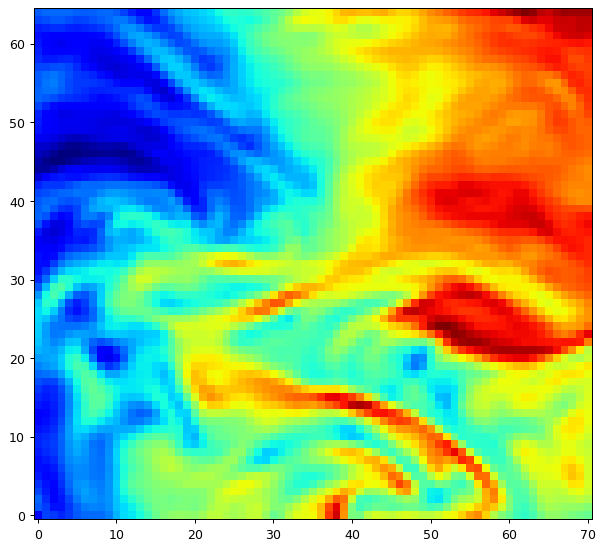

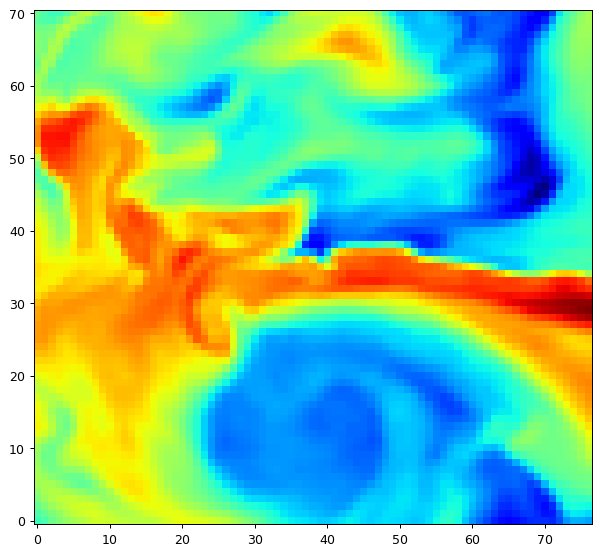

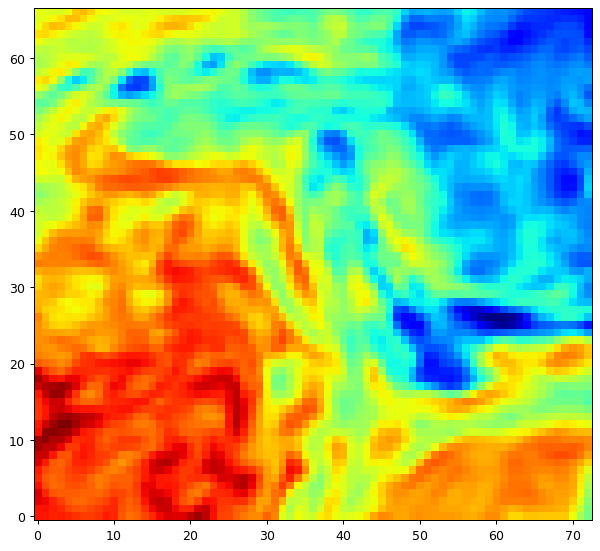

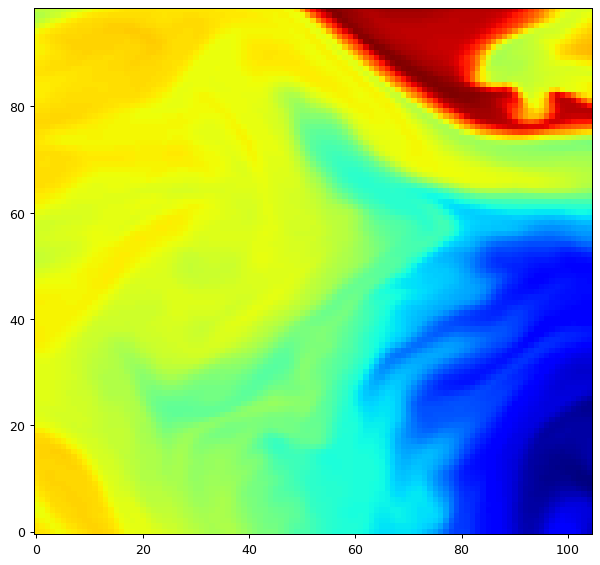

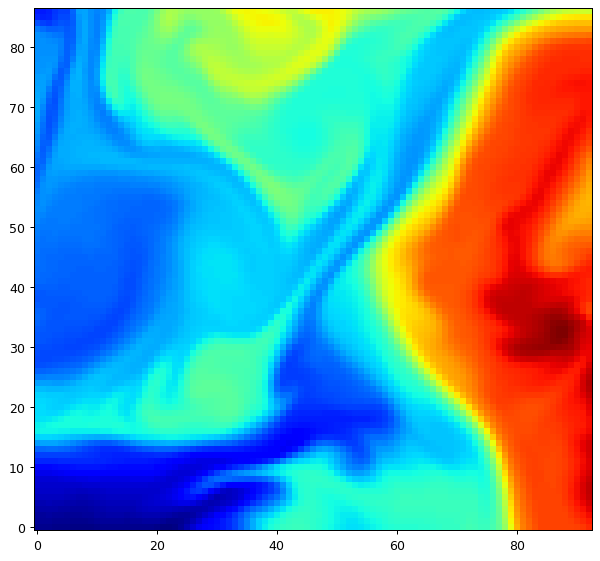

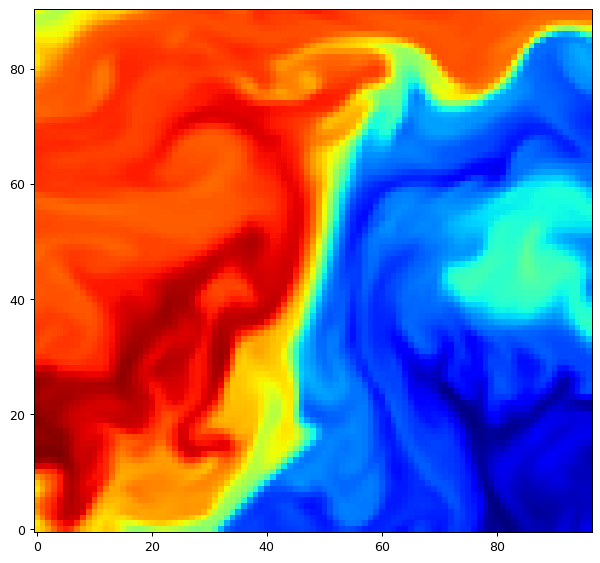

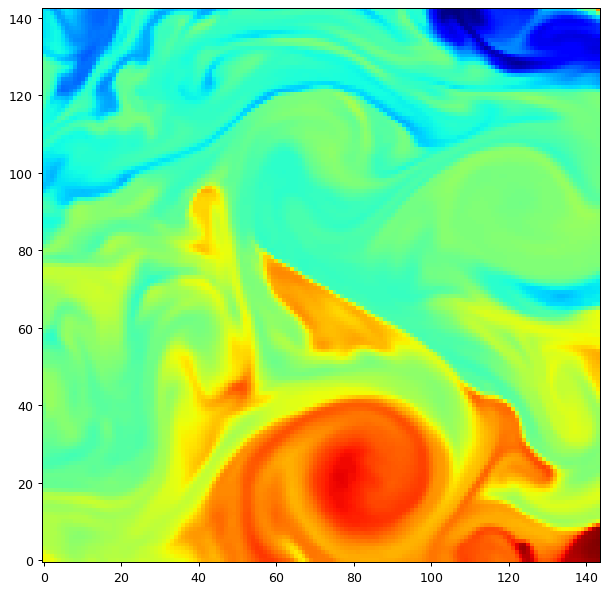

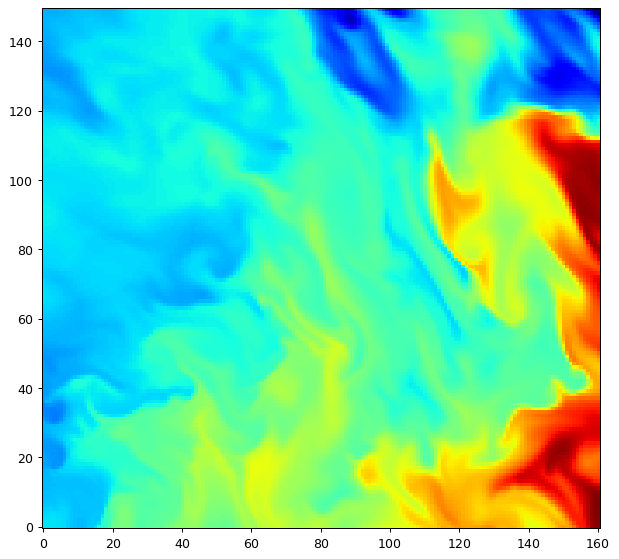

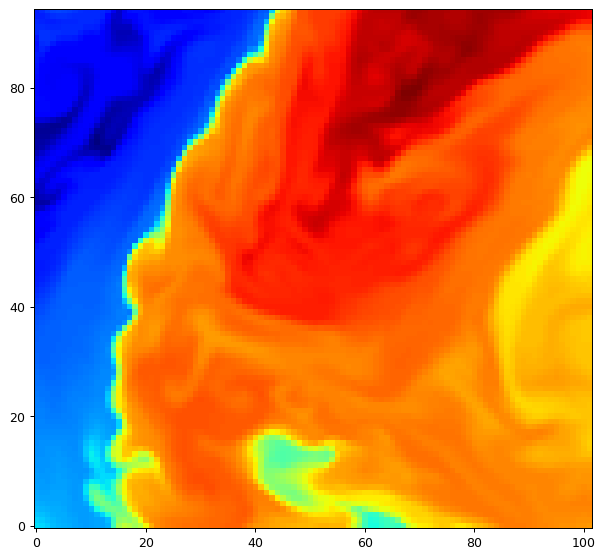

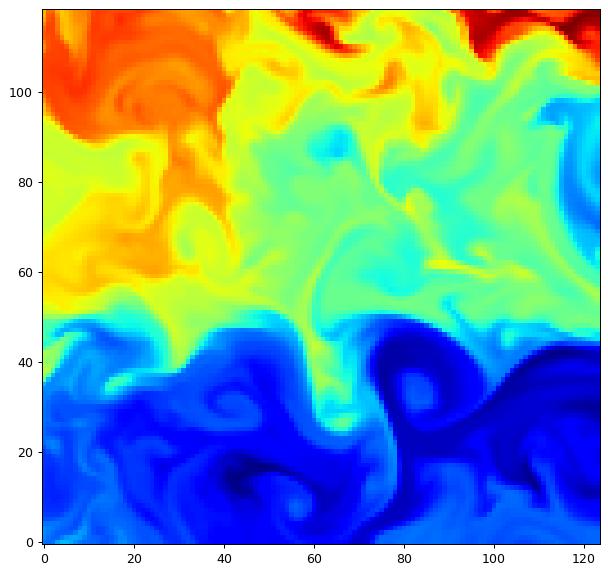

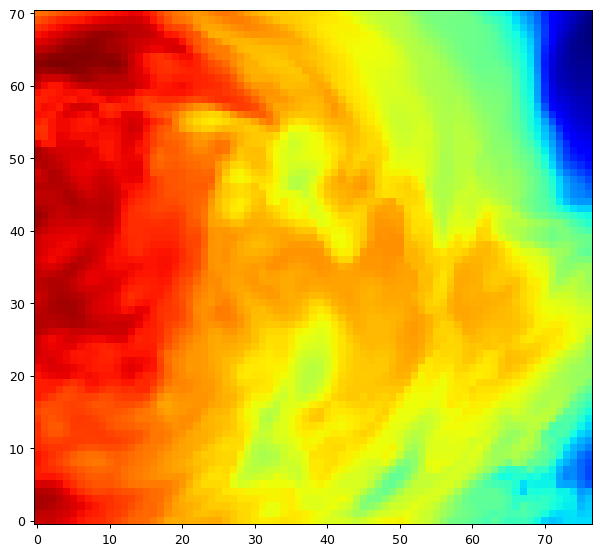

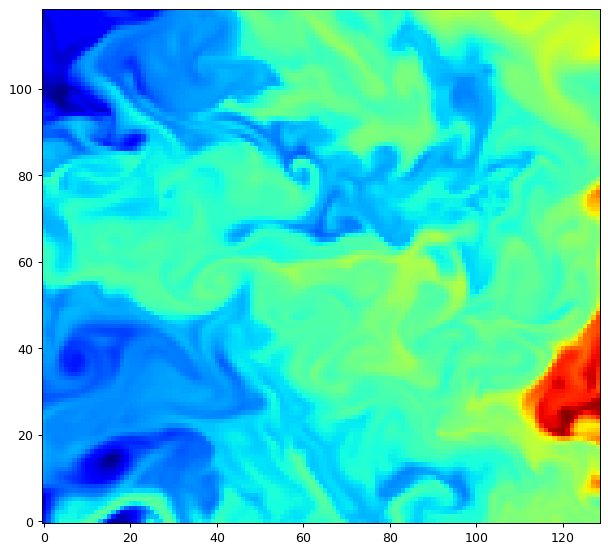

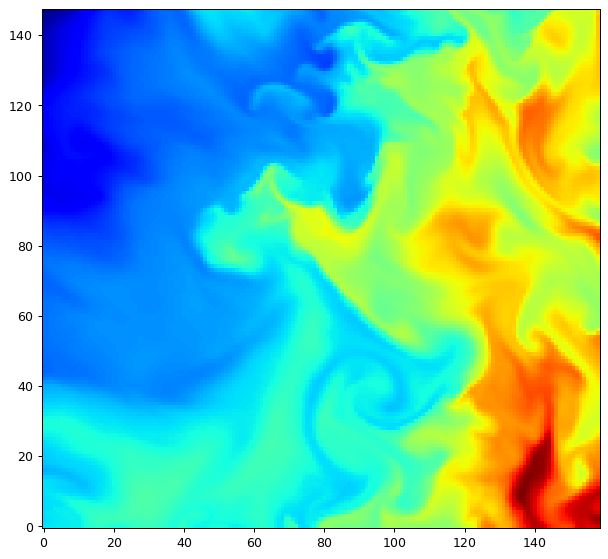

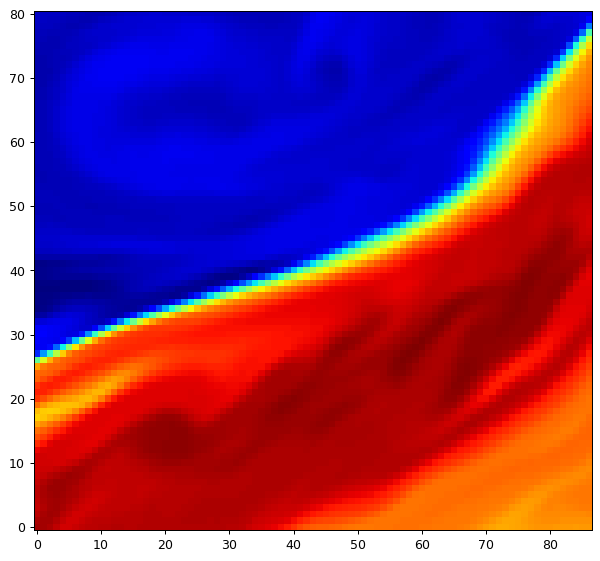

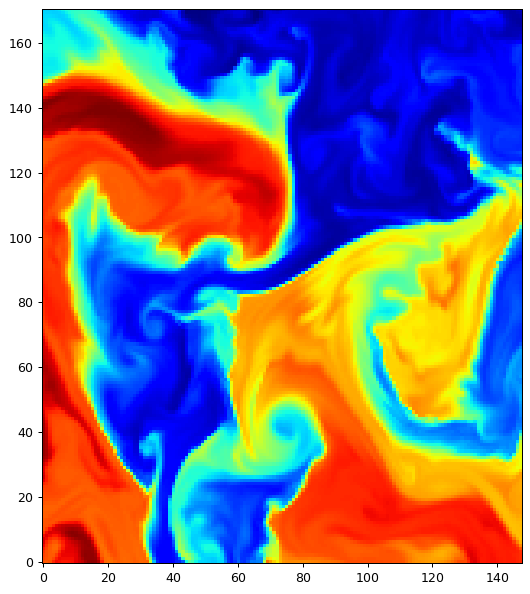

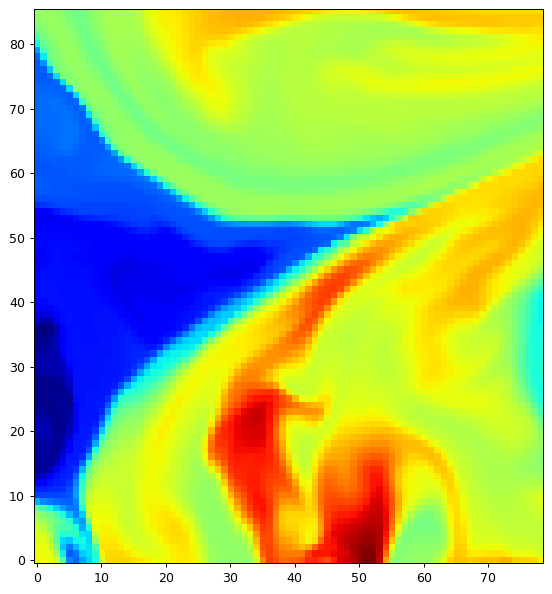

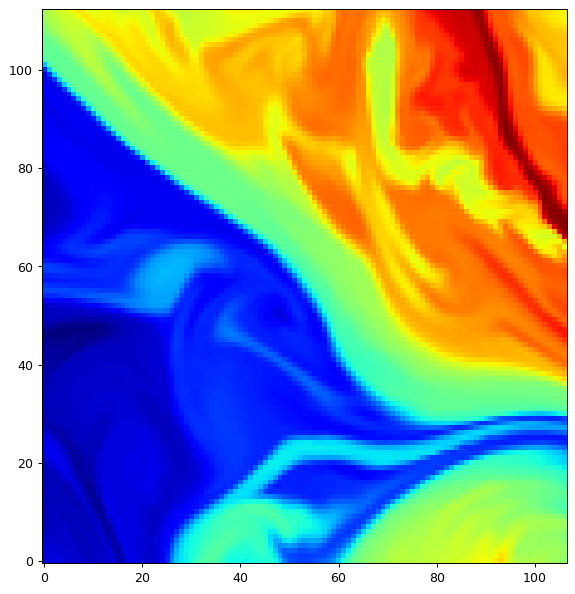

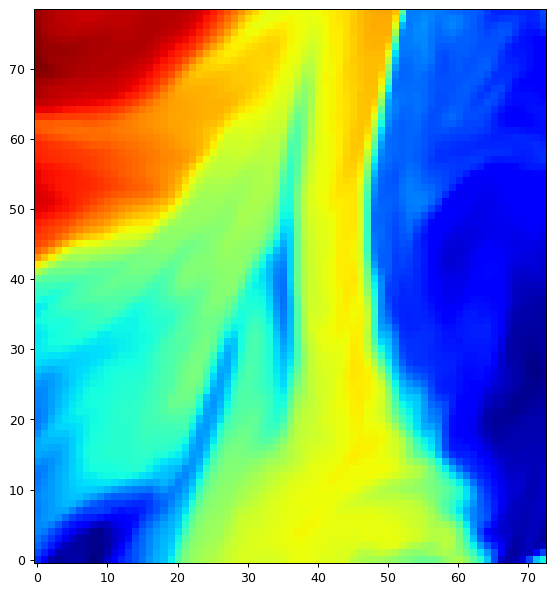

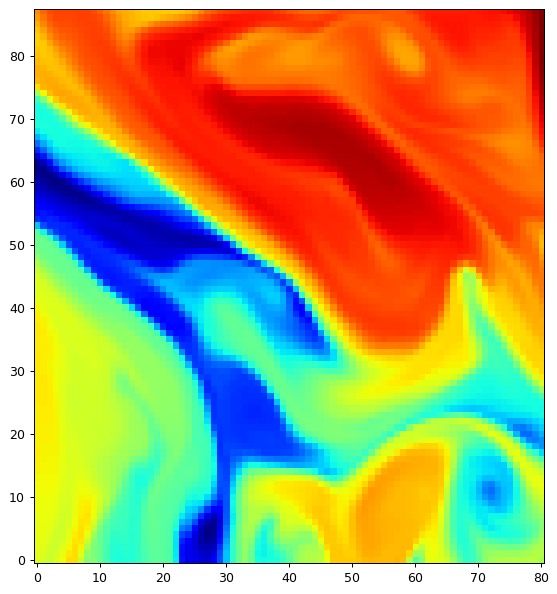

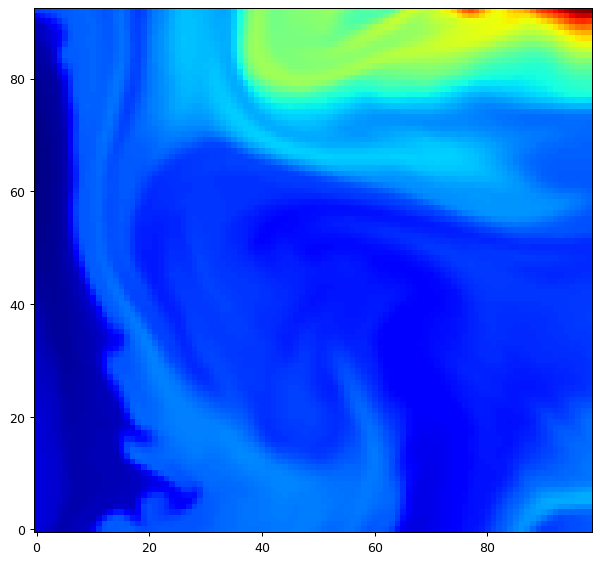

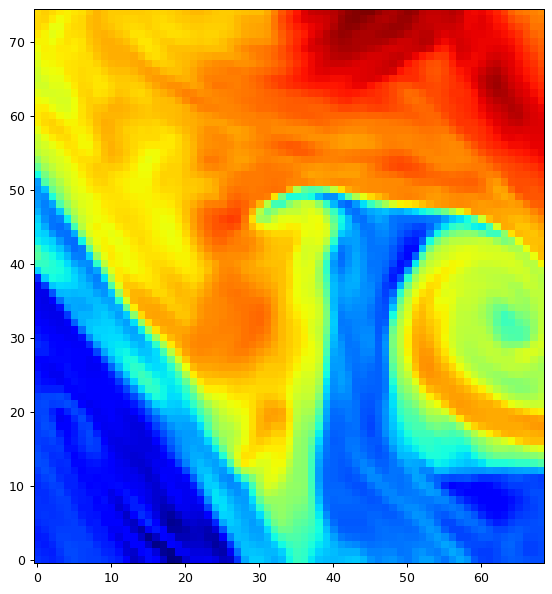

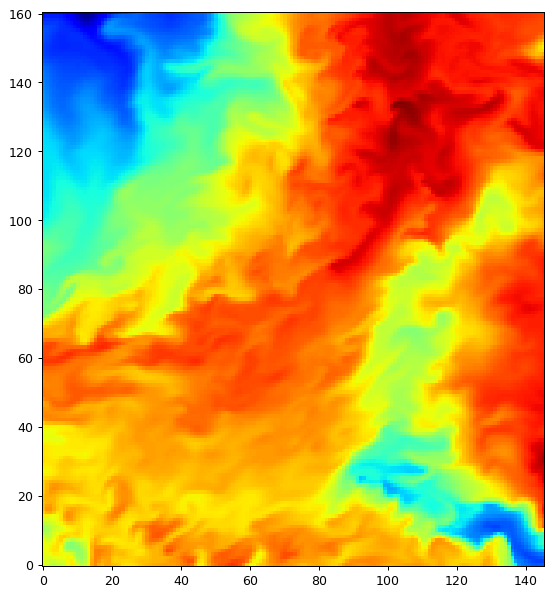

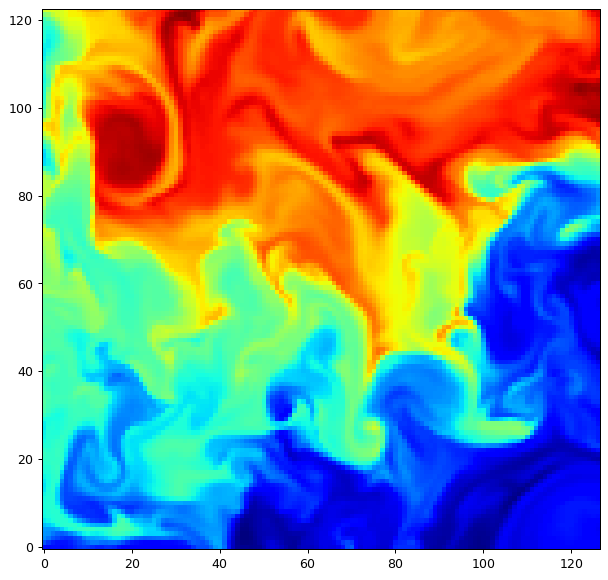

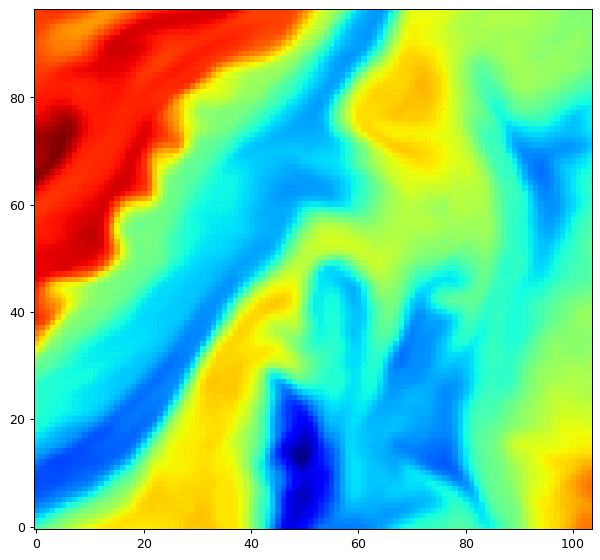

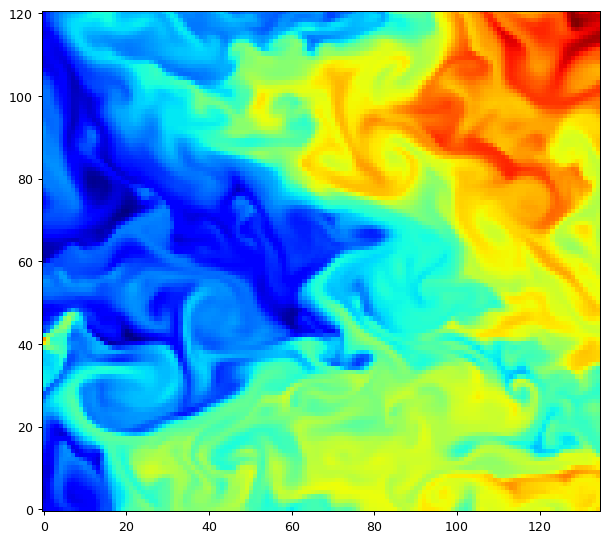

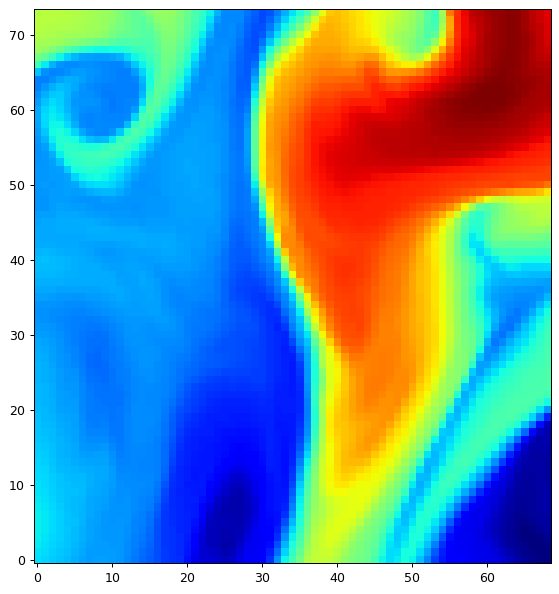

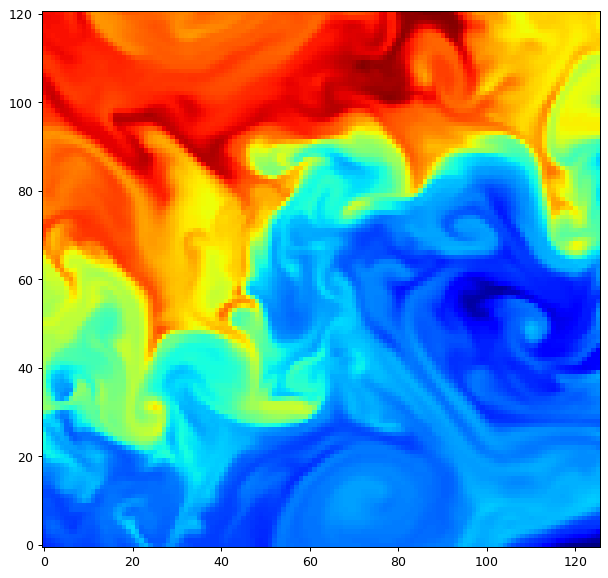

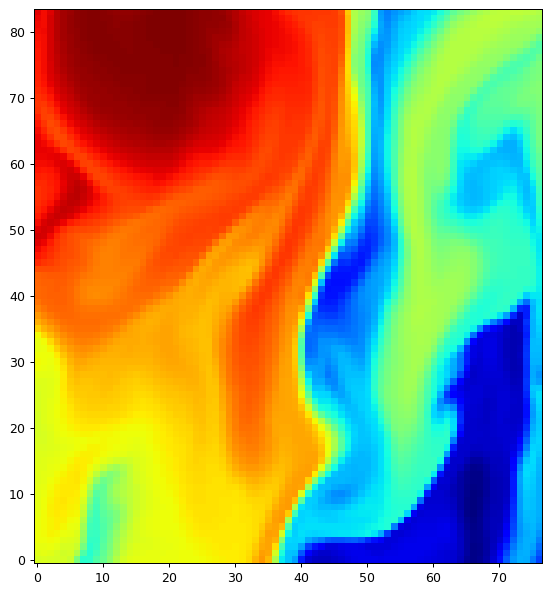

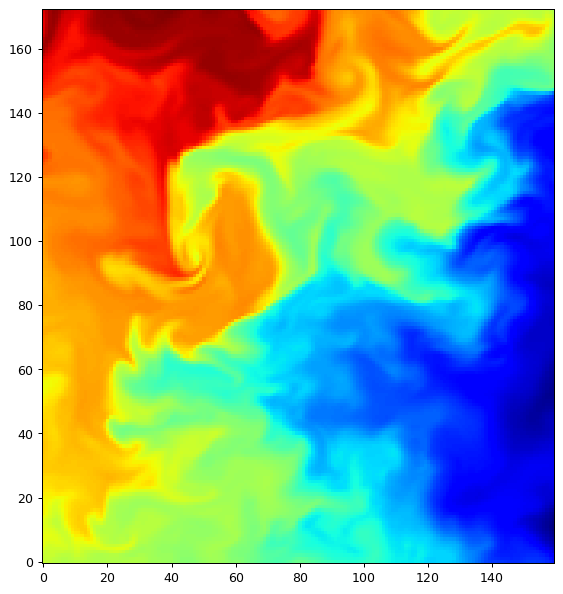

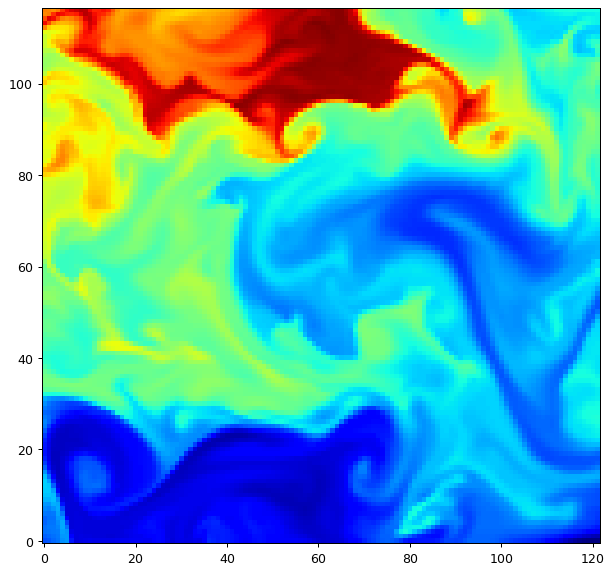

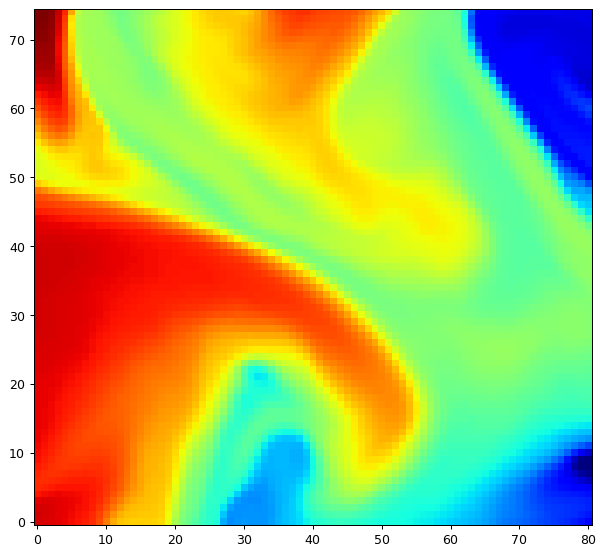

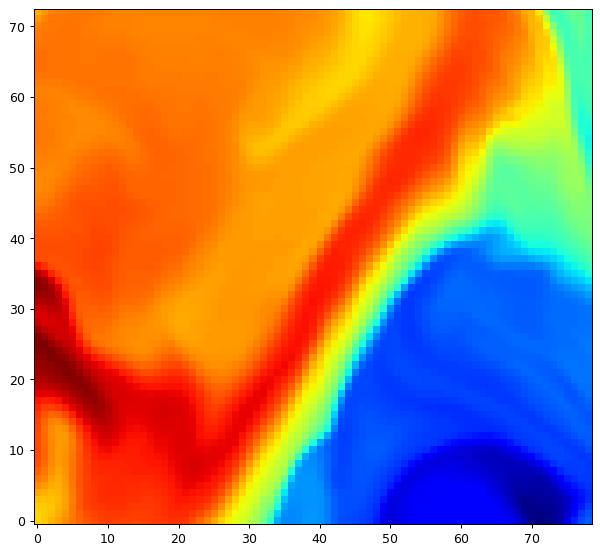

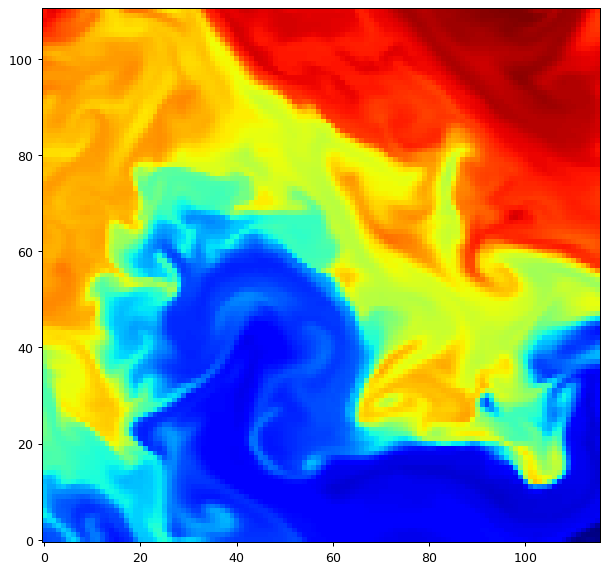

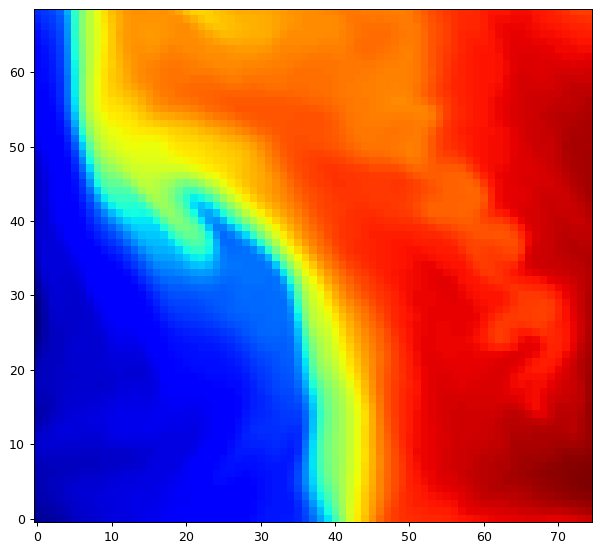

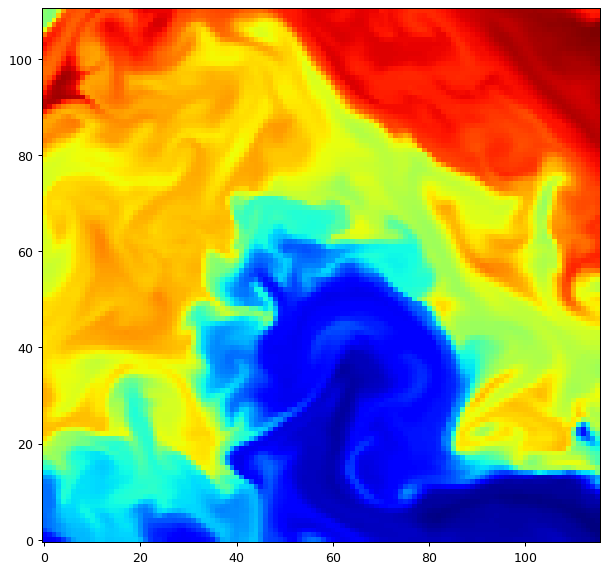

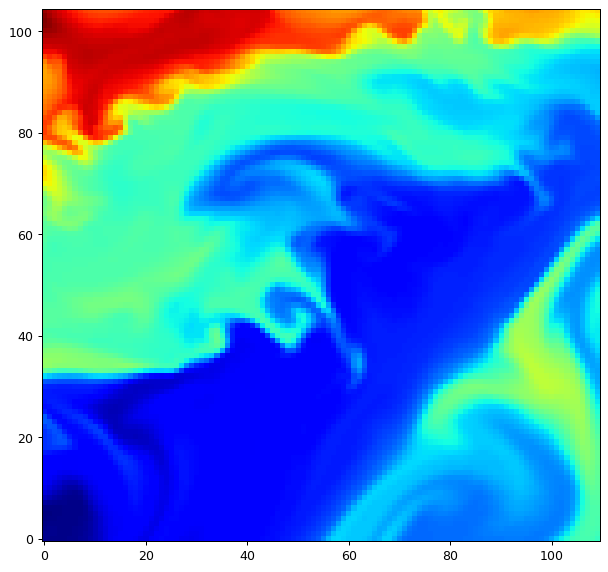

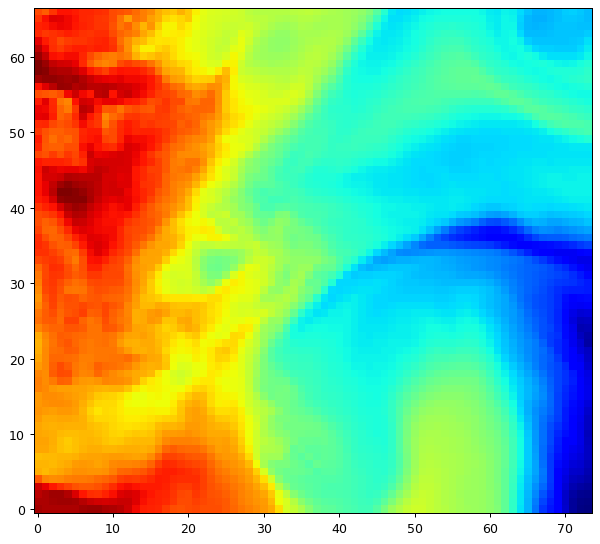

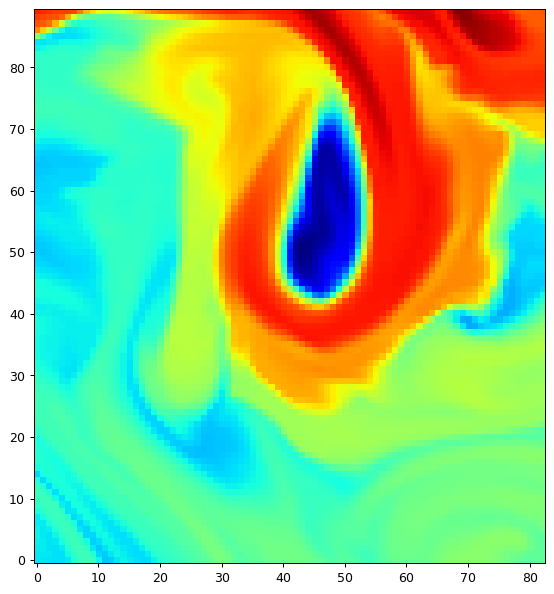

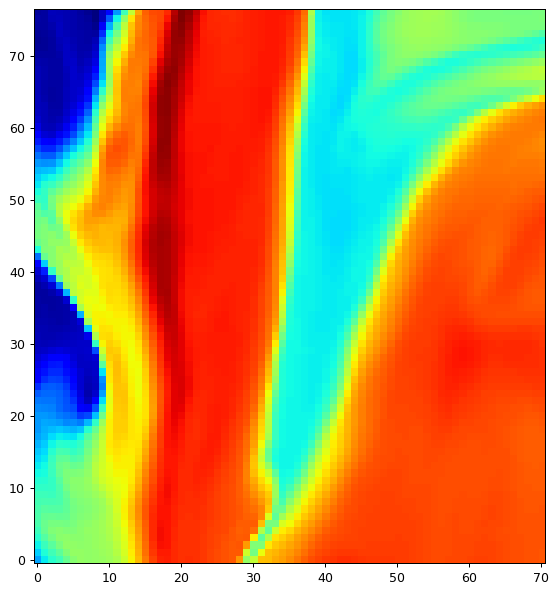

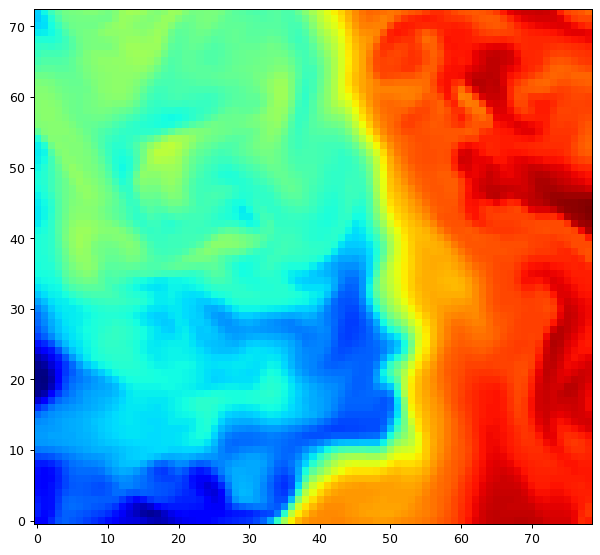

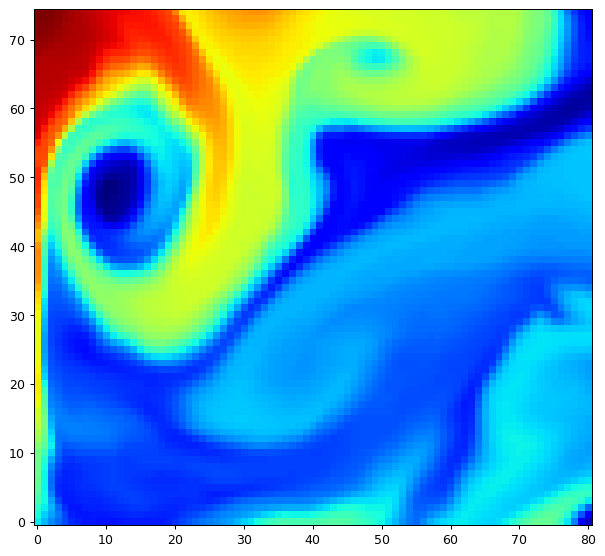

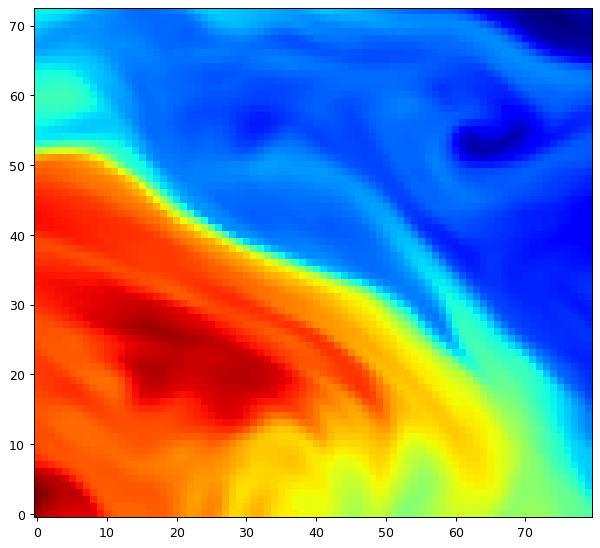

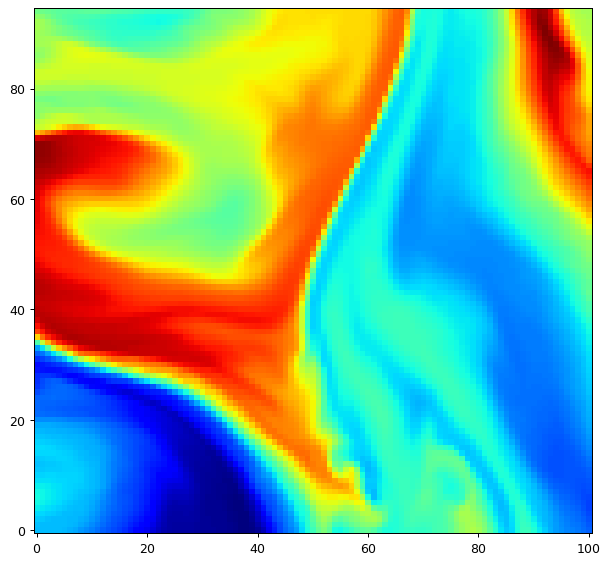

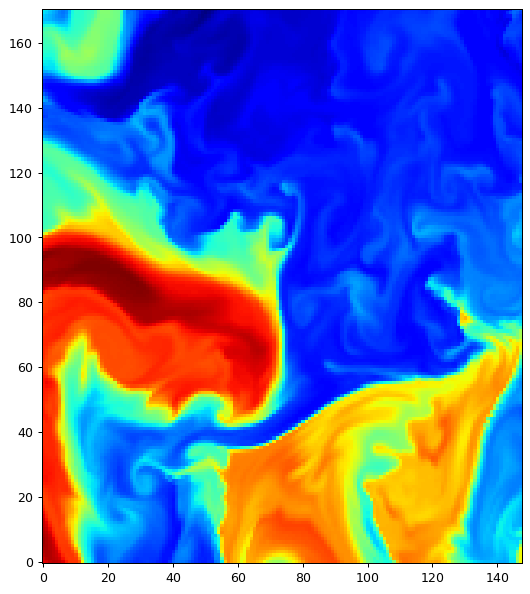

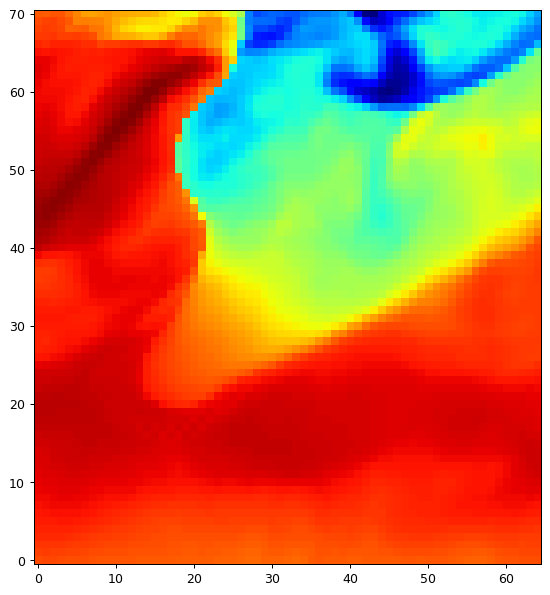

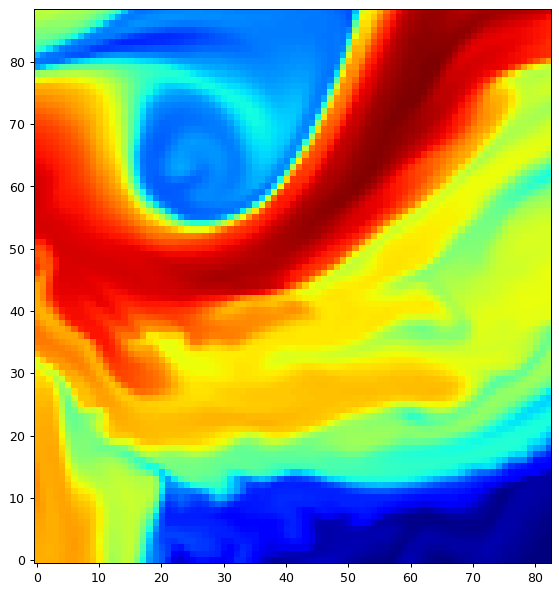

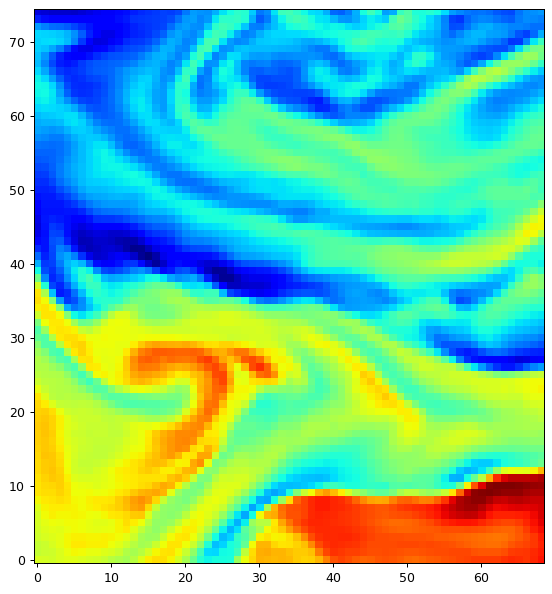

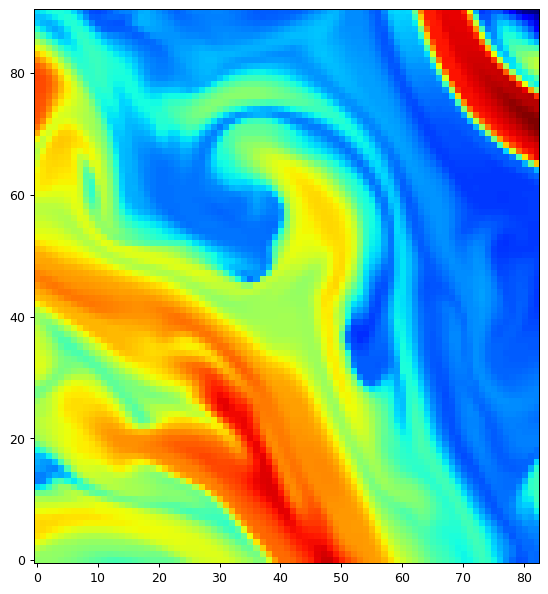

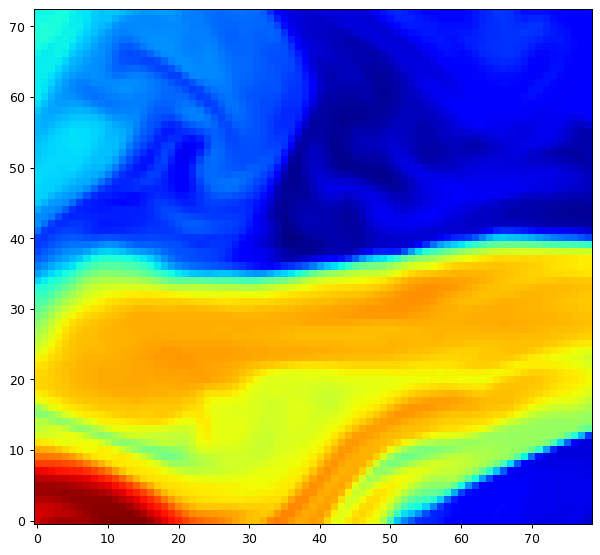

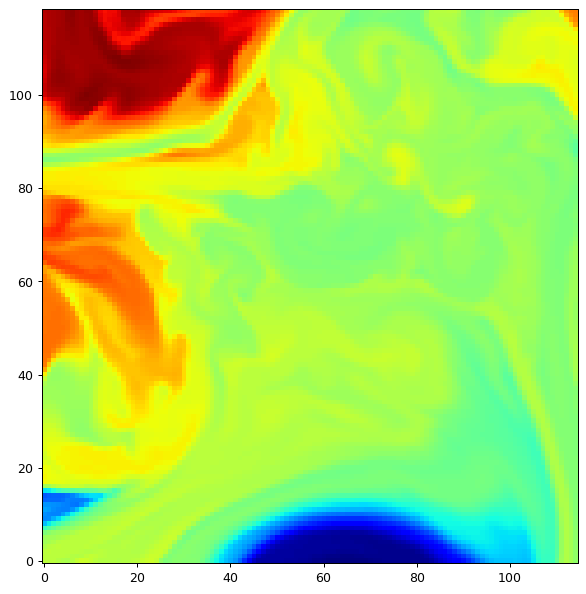

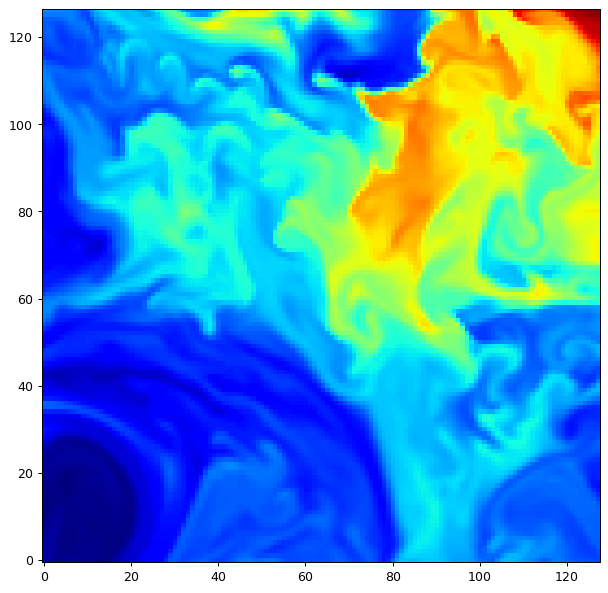

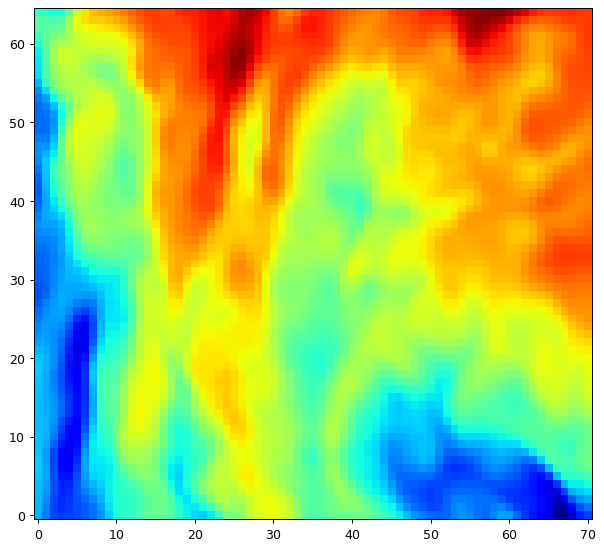

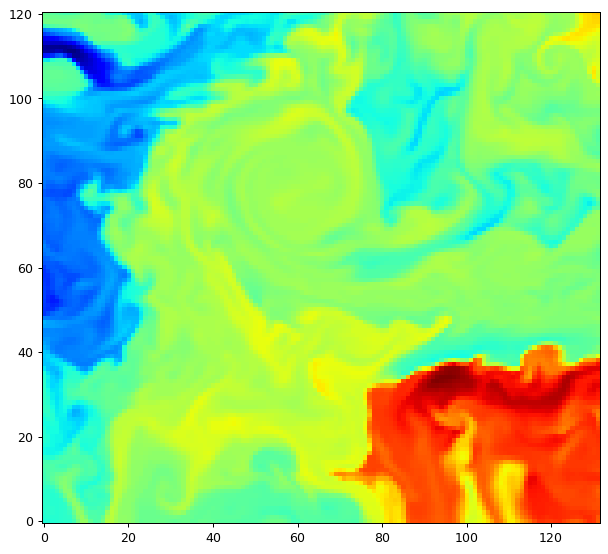

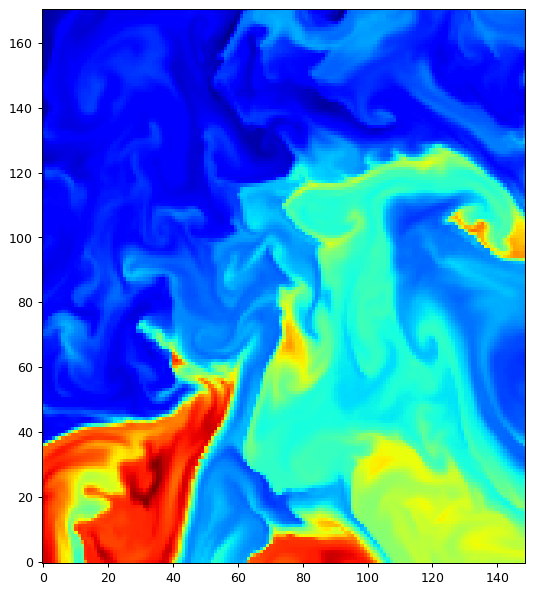

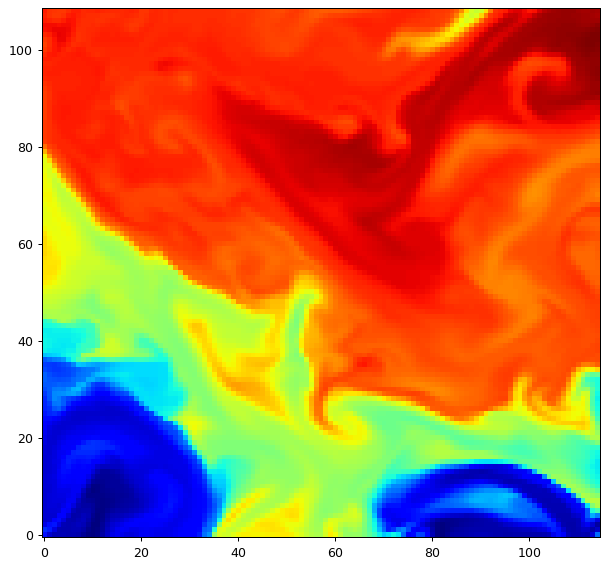

In [74]:

# print(latlon_dict["j_end"]-latlon_dict["j_start"])
# print(latlon_dict["i_end"]-latlon_dict["i_start"])
#
# print(latlon_dict["i_start"], latlon_dict["j_start"], latlon_dict["face"])
#
# print(slice(latlon_dict["j_start"], latlon_dict["j_end"] + 1))
i = 0
for patch in patches:
    # if i >= 1:
    #     break
    if patch is not None:
        patch_img = ds_merge.Theta.isel(
            face=patch["face"],
            j=slice(patch["j_start"], patch["j_end"] + 1),
            i=slice(patch["i_start"], patch["i_end"] + 1)
        )

        print(patch_img.shape)

        plt.figure(figsize=(8,8), dpi= 90)
        plt.imshow(patch_img,origin='lower',cmap='jet')
    i+=1

In [ ]:
plt.figure(figsize=(8,8), dpi= 90)
plt.imshow(data_sample[5],origin='lower',cmap='jet')

In [ ]:
#COMPARE TO ORIGINAL

patch = patches[0]
patch_img = ds_merge["W"].isel(
            face=patch["face"],
            j=slice(patch["j_start"], patch["j_end"] + 1),
            i=slice(patch["i_start"], patch["i_end"] + 1)
        )
plt.figure(figsize=(8,8), dpi= 90)
plt.imshow(patch_img,origin='lower',cmap='jet')

# Using zarr build a full dataset


In [ ]:
# print(latlon_dict["lat_min"], latlon_dict["lat_max"], latlon_dict["lon_min"], latlon_dict["lon_max"])

In [ ]:
# from ecco_v4_py import resample_to_latlon
# new_grid_delta_lat = 0.05# 0.05
# new_grid_delta_lon = 0.05#0.05
#
# center_lat = (latlon_dict["lat_min"] + latlon_dict["lat_max"]) / 2
#
# km_per_deg_lat = 111.32
# km_per_deg_lon = 111.32 * np.cos(np.deg2rad(center_lat))
#
# # desired patch half-width in km
# km_res = 0.1 # todo this is not named well
#
# # convert km to degrees
# dlat = km_res / km_per_deg_lat
# dlon = km_res / km_per_deg_lon
#
# print(dlat, dlon)
#
# theta_patch_latlon = resample_to_latlon(
#     ds_merge.XC,
#     ds_merge.YC,
#     ds_merge.Theta,
#     latlon_dict["lat_min"], latlon_dict["lat_max"],
#     dlat,
#     latlon_dict["lon_min"], latlon_dict["lon_max"],
#     dlon,
#     mapping_method='nearest_neighbor'
# )
#
# # theta_patch_latlon = resample_to_latlon(
# #     ds_merge.XC,
# #     ds_merge.YC,
# #     ds_merge.Theta,
# #     lat_min, lat_max,
# #     new_grid_delta_lat,
# #     lon_min, lon_max,
# #     new_grid_delta_lon,
# #     mapping_method='nearest_neighbor'
# # )


In [ ]:
new_grid_min_lat = -90
new_grid_max_lat = 90

new_grid_min_lon = -180
new_grid_max_lon = 180

full_interp = resample_to_latlon(
    ds_merge.XC,
    ds_merge.YC,
    ds_merge.Theta,
    new_grid_min_lat, new_grid_max_lat,
    1,
    new_grid_min_lon, new_grid_max_lon,
    1,
    mapping_method='nearest_neighbor'
)



In [ ]:
new_grid_lon_centers, new_grid_lat_centers,\
new_grid_lon_edges, new_grid_lat_edges,\
field = full_interp

plt.figure(figsize=(8,8), dpi= 90)
plt.imshow(field,origin='lower',cmap='jet')

In [ ]:
new_grid_lon_centers, new_grid_lat_centers,\
new_grid_lon_edges, new_grid_lat_edges,\
field = theta_patch_latlon

In [ ]:
plt.figure(figsize=(8,8), dpi= 90)
plt.imshow(field,origin='lower',cmap='jet')

In [ ]:
ecco.plot_proj_to_latlon_grid(ds_merge.XC,
                              ds_merge.YC,
                              log_gradb,
                              cmap=cmocean.cm.thermal,
                              plot_type = 'pcolormesh',
                              dx=0.05,
                              dy=0.05,
                              projection_type = 'robin',
                              less_output = True,
                              show_colorbar=True,
                              )

In [ ]:
dx_row = ds_merge.dxC.sel(face=face).isel(j=100).values
len(dx_row)

In [ ]:
gradb2

In [ ]:
hist

In [ ]:
# llc_plotting.plot_pdf_dask(gradb2, "|delta b|^2", bins=100)

In [ ]:
# 3 mins
vmin = gradb2.min().compute()

vmax = gradb2.max().compute()

In [ ]:
print("min:", vmin)
print("max:", vmax)

In [ ]:
# sample based on pdf

# da: dask-backed xarray with dims (face, i, j)
data = gradb2.data  # dask array

# Flatten data lazily
flat = data.reshape(-1)  # still lazy

In [ ]:
pdf, bin_edges = da.histogram(flat, bins=200, range=[flat.min().compute(), flat.max().compute()])
bin_widths = np.diff(bin_edges)
prob_mass = pdf / pdf.sum()  # probabilities for each bin

In [ ]:
llc_plotting.plot_log_pdf(gradb2, "Log-PDF of |delta b|^2")

In [ ]:
# log pdf of zonal grad b
llc_plotting.plot_log_pdf(zonal_grad_b, "Log-PDF of zonal buoyancy gradient")

In [ ]:
llc_plotting.plot_log_faces_layout(gradb2, color_map = cmocean.cm.thermal, vmin=None, vmax=None)

In [ ]:
vals = np.abs(gradb2.values.ravel())
vals = vals[(vals > 0) & ~np.isnan(vals)]
logvals = np.log10(vals)

# find vmin and max for plot
vmin = np.quantile(logvals, 0.01)
vmax = np.quantile(logvals, 0.99)

print(vmin, vmax)

# create the log values xarray for plotting
vals = np.abs(gradb2)
vals = vals.where(vals > 0)

logvals_xarray = np.log10(vals)

In [ ]:
ecco.plot_proj_to_latlon_grid(ds_merge.XC,
                              ds_merge.YC,
                              logvals_xarray,
                              cmap=cmocean.cm.thermal,
                              plot_type = 'pcolormesh',
                              dx=0.05,
                              dy=0.05,
                              projection_type = 'robin',
                              less_output = True,
                              show_colorbar=True,
                              cmin=vmin, cmax=vmax)

In [ ]:
llc_plotting.plot_log_faces_layout(zonal_grad_b, color_map = cmocean.cm.thermal, vmin=None, vmax=None)

In [ ]:
# plot of buoyancy
llc_plotting.plot_llc_faces_layout(buoyancy, "viridis")

Show Gradient Theta!

In [ ]:
plt.figure(figsize=(12,6), dpi= 90)

tmp_plt = ds_merge.Theta

ecco.plot_proj_to_latlon_grid(ds_merge.XC, \
                              ds_merge.YC, \
                              tmp_plt, \
                              plot_type = 'pcolormesh', \
                              dx=2,\
                              dy=2, \
                              projection_type = 'robin',\
                              less_output = True,
                              show_colorbar=True,cmin=-.25, cmax=.25)


In [ ]:
import matplotlib.pyplot as plt

plt.hist(ds_dx_hatx_G.values.flatten(), bins=200, density=True)
plt.xlabel("Theta")
plt.ylabel("PDF")
plt.title("PDF of Theta")
plt.show()

In [ ]:
import numpy as np

vals = np.abs(ds_dx_hatx_G.values.ravel())
vals = vals[(vals > 0) & ~np.isnan(vals)]

logvals = np.log10(vals)

plt.hist(logvals, bins=200, density=True)
plt.xlabel("log10(|value|)")
plt.ylabel("PDF")
plt.title("Log-PDF of gradient")
plt.show()

In [ ]:
vals = np.abs(ds_dx_hatx_G)
vals = vals.where(vals > 0)

logvals = np.log10(vals)

vmin = float(logvals.quantile(0.01))
vmax = float(logvals.quantile(0.99))

print(vmin, vmax)

plt.figure(figsize=(12,6), dpi= 90)

ecco.plot_proj_to_latlon_grid(ds_merge.XC,
                              ds_merge.YC,
                              logvals,
                              cmap="viridis",
                              plot_type = 'pcolormesh',
                              dx=0.25,
                              dy=0.25,
                              projection_type = 'robin',
                              less_output = True,
                              show_colorbar=True,
                              cmin=vmin, cmax=vmax)

In [ ]:
llc_plotting.plot_llc_faces_layout(logvals, "viridis", vmin=vmin, vmax=vmax)

In [ ]:
llc_plotting.plot_llc_faces_layout(buoyancy, "viridis")

Leftover plotting stuff :

In [ ]:
# # plot theta
# llc_plotting.plot_llc_faces_layout(ds_merge.Theta)

In [ ]:
# #downsample plotting by real coordinates
# i_sub = slice(None, None, 40)
# j_sub = slice(None, None, 40)
#
# # Select theta for this face
# theta_face = ds_merge.Theta.isel(face=3)
#
# # Assign real coordinates
# theta_face = theta_face.assign_coords(x=ds_merge.XC.isel(face=3),
#                                       y=ds_merge.YC.isel(face=3))
#
# # Now xarray will use these for plotting
# theta_face.plot(x='x', y='y', cmap='jet', figsize=(12,8))

In [ ]:
# import matplotlib.pyplot as plt
#
# face = 0
# plt.figure(figsize=(10, 8))
# plt.pcolormesh(ds_merge_sub.XC.isel(face=face),
#                ds_merge_sub.YC.isel(face=face),
#                ds_merge_sub.SN.isel(face=face),
#                cmap='jet', shading='auto')
# plt.title(f"SN for Face {face}")
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
# plt.show()

In [ ]:
# face = 6
# var = "Theta"
#
# var_at_face = ds_merge[var][face]
#
# var_at_face

In [ ]:
# # Confirm the location of the gradients in 'X' and 'Y' are at the 'u' and 'v' points, respectively.
# print(f'ds_dx_hatx_M: {ds_dx_hatx_M.shape, ds_dx_hatx_M.dims}')
# print(f'ds_dy_haty_M: {ds_dy_haty_M.shape, ds_dy_haty_M.dims}')

In [ ]:
# cmap = plt.cm.viridis.copy()            # make a copy of your colormap
# cmap.set_bad(color='red')               # NaNs will appear red

In [ ]:
# # plot dxc
# llc_plotting.plot_llc_faces_layout(ds_merge.dyC, cmocean.cm.diff)


In [ ]:
#min_val = ds_dy_haty_M.min().compute().item()

In [ ]:
#max_val = ds_dy_haty_M.max().compute().item()

In [ ]:
# print(min_val)
# print(max_val)

In [ ]:
# plot_llc_faces_layout(ds_dy_haty_M, cmocean.cm.diff) # vmin=-3e-4, vmax=3e-4)
#
# # plot_a_face_by_var(ds_dy_haty_M, 6, cmap, vmin=-3e-6, vmax=3e-6)

In [ ]:
#Merid
llc_plotting.plot_llc_faces_layout(ds_dy_haty_G, cmocean.cm.diff)

In [ ]:
# theta and vertical grad
llc_plotting.plot_a_face_by_two_var(ds_merge.Theta, ds_dy_haty_G, "Theta", "Meridional Gradient", 1)

#vmin1=-1e-6, vmax1=1e-6)
# theta sea ice : -1.8 - 0

In [ ]:


plt.figure(figsize=(12,6), dpi= 90)

tmp_plt = ds_dx_hatx_G

ecco.plot_proj_to_latlon_grid(ds_merge.XC,
                              ds_merge.YC,
                              tmp_plt,
                              cmap='RdBu_r',
                              plot_type = 'pcolormesh',
                              dx=0.25,
                              dy=0.25,
                              projection_type = 'robin',
                              less_output = True,
                              show_colorbar=True,
                              cmin=-1e-4, cmax=1e-4)

In [ ]:
ds_dx_hatx_G

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs



sm = llcreader.llcmodel.faces_dataset_to_latlon(ds_merge, metric_vector_pairs=[]).Theta
XCm = llcreader.llcmodel.faces_dataset_to_latlon(ds_merge.XC, metric_vector_pairs=[])
YCm = llcreader.llcmodel.faces_dataset_to_latlon(ds_merge.YC, metric_vector_pairs=[])


# the model grid is in PlateCarree (regular lon/lat)
data_crs = ccrs.PlateCarree()

fig = plt.figure(figsize=(10, 6))

ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines()

# plotting your model data at the correct lon/lat locations
pcm = ax.pcolormesh(
    XCm, YCm, sm,
    transform=data_crs,
    shading='auto'
)

plt.colorbar(pcm, ax=ax, label='Theta')
plt.show()

In [ ]:
s.shape

In [ ]:
import ecco_v4_py as ecco

ecco.plot_proj_to_latlon_grid(ds_merge.XC, ds_merge.YC, ds_dx_hatx_G,
                               dx=.5, dy=.5, show_colorbar=True, user_lon_0=0)

In [ ]:
#plot_a_face_by_var(ds_dy_haty_G, 1)
# todo make this a plot function


# plot in lat lon
lat_lon_merid_grad = ds_dy_haty_G.isel(face=6)

# Assign real coordinates
theta_face_latlon = lat_lon_merid_grad.assign_coords(x=ds_dy_haty_G.XC.isel(face=6),
                                      y=ds_dy_haty_G.YC.isel(face=6))

# Now xarray will use these for plotting
theta_face_latlon.plot(x='x', y='y', cmap=cmocean.cm.thermal, figsize=(12,8))

In [ ]:
print(ds_dy_haty_G[0].min().compute().item())